<a id='top'></a>
<div class="list-group" id="list-tab" role="tablist">
    
<h1 style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:190%"><b> Table of contents </b></h1>
    
* [**Imports**](#1)
* [**Pre-Processing Dataset**](#2)
* [**EDA**](#3)
* [**Feature selection and Splitting data**](#4)
* [**Modelling Stage**](#5)
    * [**Random Forest**](#5_1)
    * [**LSTM (Keras)**](#5_2)
    * [**Unsupervised Learning AutoEncoder**](#5_3)
    * [**Unsupervised Learning K Means**](#5_4)
    * [**RL Deep Q Learning**](#5_5)



<a id='1'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:80%"> <b>Imports</b>
   

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import ADASYN
import tensorflow as tf


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


<a id='2'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:80%"> <b>Pre-processing Dataset</b>

In [3]:

def read_parquet_folder(folder_path):
    # List to hold dataframes
    dfs = []

    # Loop through all files in the folder
    for file in os.listdir(folder_path):
        if file.endswith('.parquet'):
            file_path = os.path.join(folder_path, file)

            # Read the parquet file
            df = pd.read_parquet(file_path)

            # Append to the list
            dfs.append(df)

    # Concatenate all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)

    return combined_df

# Specify the path to your folder
folder_path = 'datasets/MachineLearningCVE'

# Read and combine data
df = read_parquet_folder(folder_path)


In [4]:
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
print(categorical_cols)

Index(['Label'], dtype='object')


No categorical columns, all numerical

<a id='3'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:80%"> <b>Exploritory Data Analysis</b>

In [5]:
df.Label.value_counts()


Label
Benign                        1977318
DoS Hulk                       172846
DDoS                           128014
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
PortScan                         1956
Web Attack � Brute Force         1470
Bot                              1437
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64

### Combine similar attack types
Increases multi class classification accuracy<br>
Reducing Noise and Overfitting<br>
Enhancing Interpretability<br>
Handling Imbalanced Data<br>

In [6]:
df_experiment = df.copy()

# Replace various Web Attack types with a single label "Web Attack"
df_experiment['Label'] = df_experiment['Label'].str.replace(r'Web Attack.*', 'Web Attack', regex=True)

# Replace FTP-Patator and SSH-Patator with "Brute Force"
df_experiment['Label'] = df_experiment['Label'].replace(r'.*Patator$', 'Brute Force', regex=True)

# Consolidate various DoS attack types into a single "DoS" label
df_experiment['Label'] = df_experiment['Label'].replace(["DoS GoldenEye", "DoS Hulk", "DoS Slowhttptest", "DoS slowloris"], "DoS")

# Ensure that only the following 9 labels exist in the dataset
desired_labels = ["Benign", "DoS", "DDoS", "Brute Force", "PortScan", "Web Attack", "Bot", "Infiltration", "Heartbleed"]

# Replace any label not in desired_labels with 'Other'
df_experiment['Label'] = df_experiment['Label'].apply(lambda x: x if x in desired_labels else 'Other')

# Check the value counts to ensure there are only 9 labels
label_counts = df_experiment['Label'].value_counts()
print(label_counts)

Label
Benign          1977318
DoS              193745
DDoS             128014
Brute Force        9150
Web Attack         2143
PortScan           1956
Bot                1437
Infiltration         36
Heartbleed           11
Name: count, dtype: int64


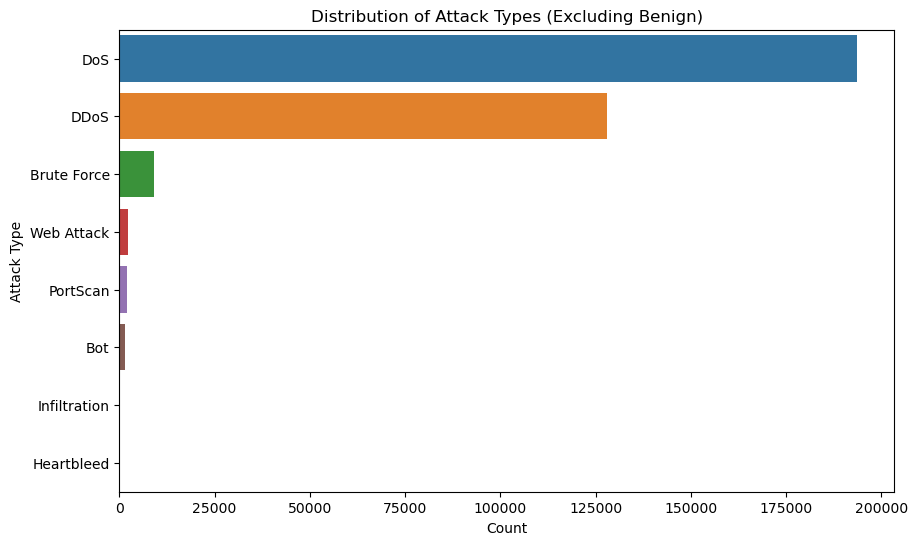

In [7]:
# Assuming 'df_experiment' is already defined and available in this context
# Filtering out the 'Benign' label
df_filtered123 = df_experiment[df_experiment['Label'] != 'Benign']

# Count plot for different labels, excluding 'Benign'
plt.figure(figsize=(10, 6))
sns.countplot(y='Label', data=df_filtered123, order=df_filtered123['Label'].value_counts().index)
plt.title('Distribution of Attack Types (Excluding Benign)')
plt.xlabel('Count')
plt.ylabel('Attack Type')
plt.show()

C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


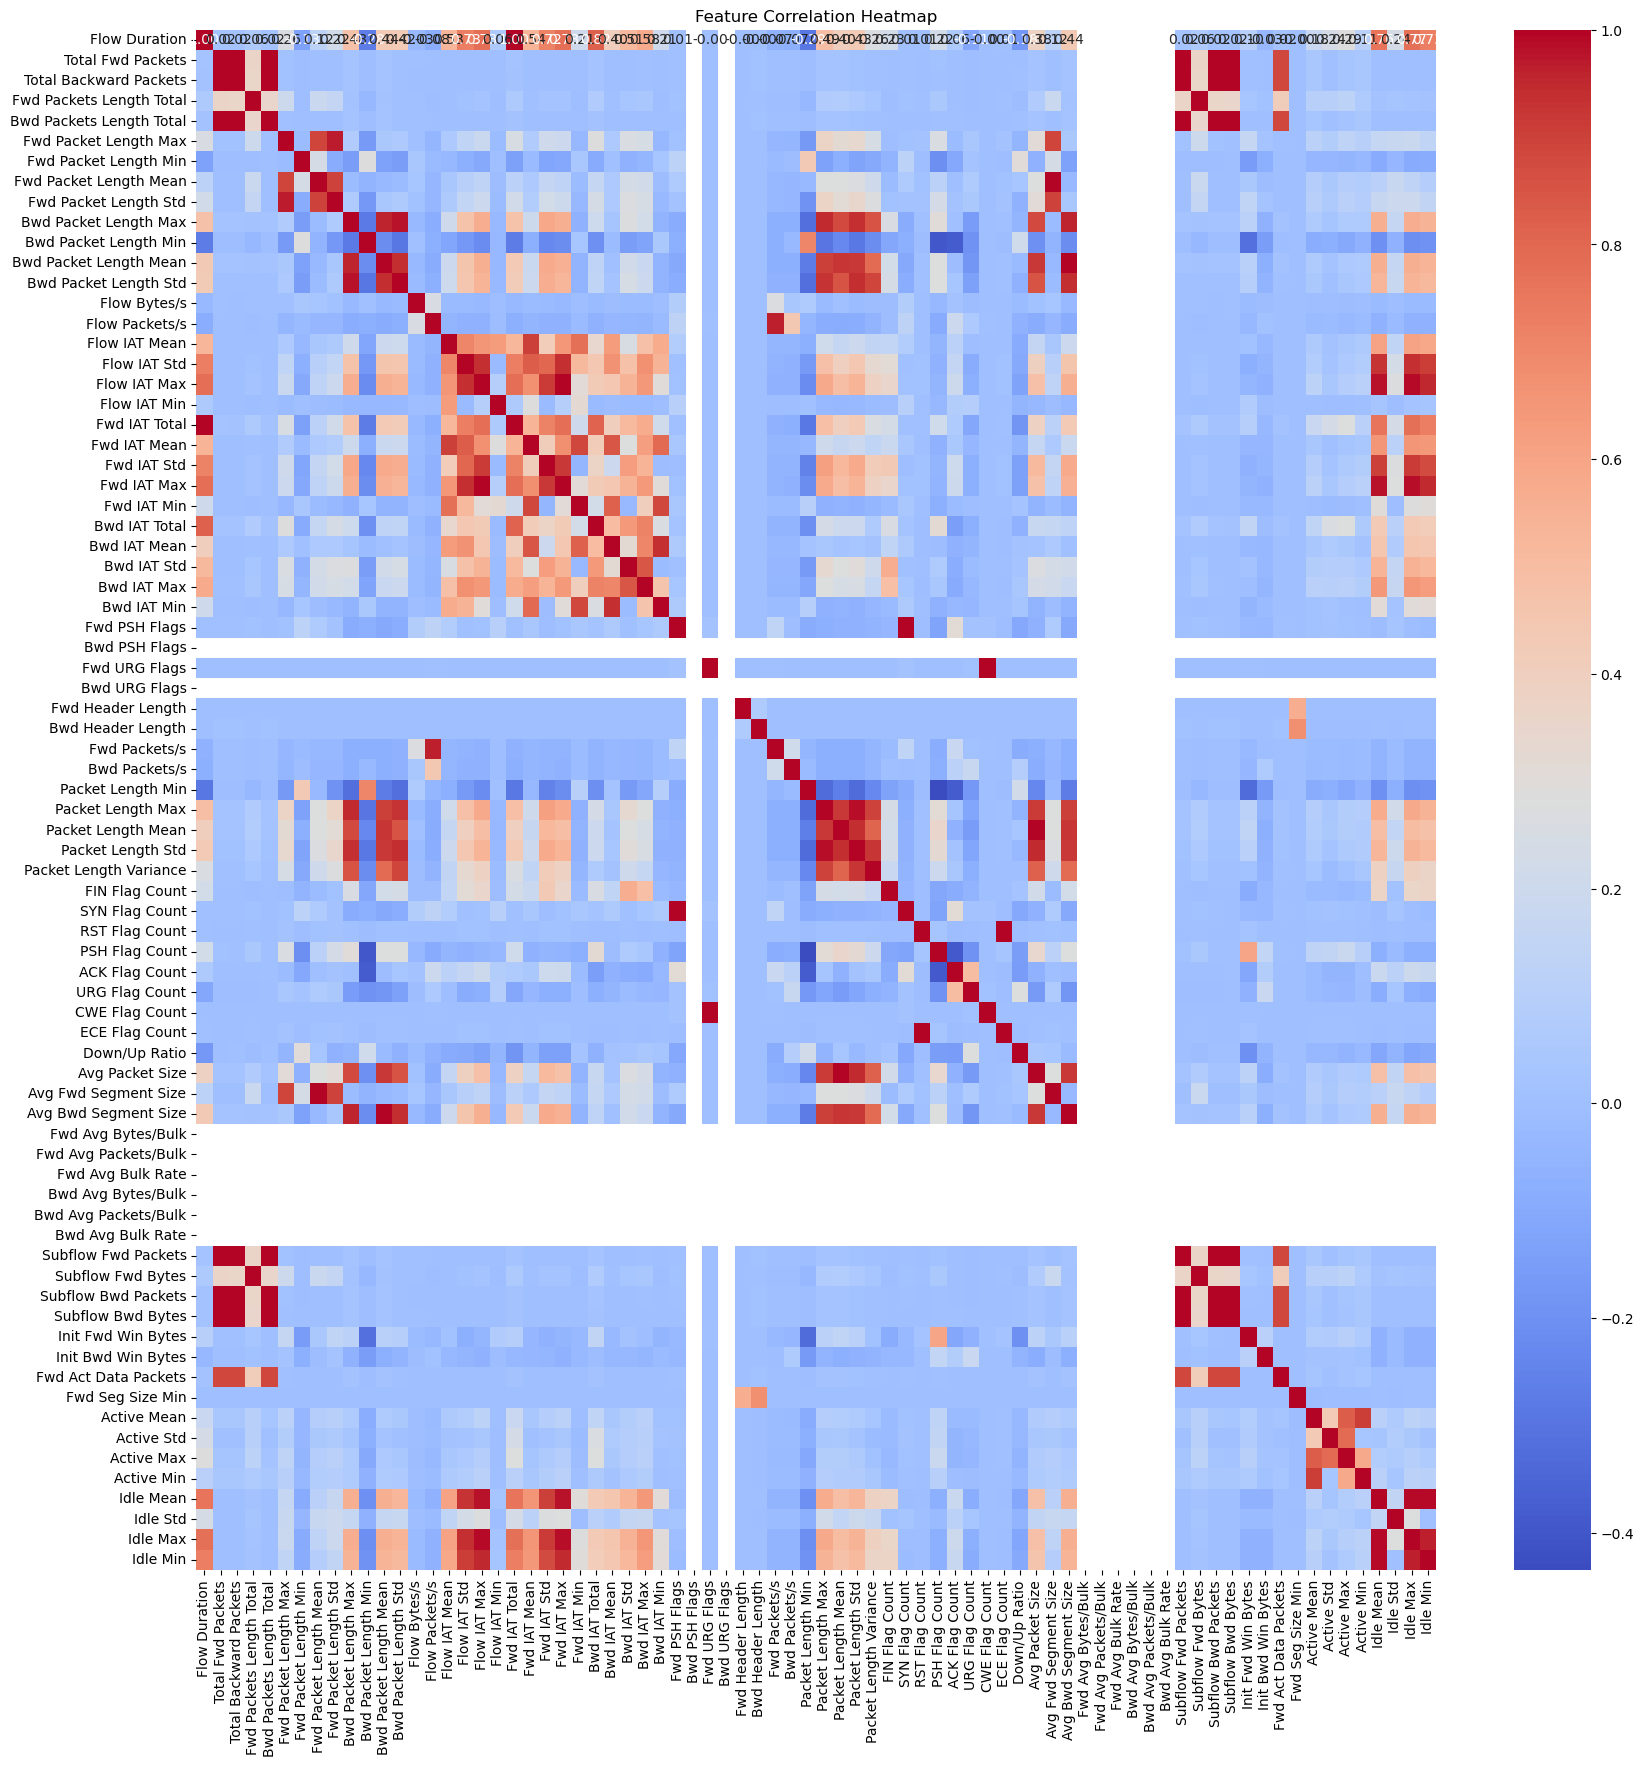

In [8]:
# Compute the correlation matrix
correlation_matrix = df_experiment.drop(columns=['Label']).corr()

# Generate a heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

<a id='4'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:80%"> <b>Feature Extraction and Splitting data</b>

Remove label column to do feature extraction on the data

In [7]:
dfu = df_experiment.drop(columns=['Label'])

### Scaling data first

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to the data and transform it
df_scaled = pd.DataFrame(scaler.fit_transform(dfu), columns=dfu.columns)


In [9]:
df_scaled.head()

Flow Duration  Total Fwd Packets  Total Backward Packets  \
0   1.333333e-07           0.000005                0.000000   
1   1.016667e-06           0.000000                0.000003   
2   5.416666e-07           0.000000                0.000003   
3   3.916666e-07           0.000000                0.000003   
4   1.333333e-07           0.000005                0.000000   

   Fwd Packets Length Total  Bwd Packets Length Total  Fwd Packet Length Max  \
0              9.302326e-07              0.000000e+00               0.000242   
1              4.651163e-07              9.153974e-09               0.000242   
2              4.651163e-07              9.153974e-09               0.000242   
3              4.651163e-07              9.153974e-09               0.000242   
4              9.302326e-07              0.000000e+00               0.000242   

   Fwd Packet Length Min  Fwd Packet Length Mean  Fwd Packet Length Std  \
0               0.002581                 0.00101                    0.0   
1               0.002581                 0.00101                    0.0   
2               0.002581                 0.00101                    0.0   
3               0.002581                 0.00101                    0.0   
4               0.002581                 0.00101                    0.0   

   Bwd Packet Length Max  ...  Fwd Act Data Packets  Fwd Seg Size Min  \
0               0.000000  ...              0.000005               1.0   
1               0.000307  ...              0.000000               1.0   
2               0.000307  ...              0.000000               1.0   
3               0.000307  ...              0.000000               1.0   
4               0.000000  ...              0.000005               1.0   

   Active Mean  Active Std  Active Max  Active Min  Idle Mean  Idle Std  \
0          0.0         0.0         0.0         0.0        0.0       0.0   
1          0.0         0.0         0.0         0.0        0.0       0.0   
2          0.0         0.0         0.0         0.0        0.0       0.0   
3          0.0         0.0         0.0         0.0        0.0       0.0   
4          0.0         0.0         0.0         0.0        0.0       0.0   

   Idle Max  Idle Min  
0       0.0       0.0  
1       0.0       0.0  
2       0.0       0.0  
3       0.0       0.0  
4       0.0       0.0  

[5 rows x 76 columns]

### Training and Test split
**Also Add attack category Label for prediction** <br>
**Add training set with synthetic samples using ADASYN for minority samples**

In [10]:
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming df_scaled and df_experiment are already defined

X = df_scaled
y = df_experiment['Label']

# Separate the specified majority classes and the rest
majority_mask = y.isin(['Benign', 'DDoS', 'DoS'])
X_majority = X[majority_mask]
y_majority = y[majority_mask]

X_minority = X[~majority_mask]
y_minority = y[~majority_mask]

# Reduce the majority classes to 30% of their original size
X_majority_reduced, _, y_majority_reduced, _ = train_test_split(X_majority, y_majority, test_size=0.7, random_state=42)
del X_majority, y_majority  # Delete variables no longer needed

# Combine the reduced majority classes with the untouched minority classes
X_combined = pd.concat([X_majority_reduced, X_minority], ignore_index=True)
y_combined = pd.concat([y_majority_reduced, y_minority], ignore_index=True)
del X_majority_reduced, y_majority_reduced, X_minority, y_minority  # Delete intermediate variables

# Now, split the combined dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)
del X_combined, y_combined  # Delete the combined datasets after splitting

# Reset the indices of X_train and y_train
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Apply the same logic for separating and recombining for the training set
mask_train = y_train.isin(['DoS', 'Benign'])
X_normal_train = X_train[mask_train]
y_normal_train = y_train[mask_train]

X_other_train = X_train[~mask_train]
y_other_train = y_train[~mask_train]

# Initialize BorderlineSMOTE
bsmote = BorderlineSMOTE(random_state=42, sampling_strategy='auto')

# Apply BorderlineSMOTE to the training data
X_other_resampled, y_other_resampled = bsmote.fit_resample(X_other_train, y_other_train)
del X_other_train, y_other_train  # Delete the other class datasets after resampling

# Combine the datasets
X_train_resampled = pd.concat([X_normal_train, X_other_resampled], ignore_index=True)
y_train_resampled = pd.concat([y_normal_train, y_other_resampled], ignore_index=True)
del X_normal_train, y_normal_train, X_other_resampled, y_other_resampled  # Delete temporary datasets

# X_train_resampled and y_train_resampled are now ready for use

In [11]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))



                     df_scaled:  1.3 GiB
                             X:  1.3 GiB
                            df: 686.7 MiB
                 df_experiment: 685.5 MiB
                           dfu: 547.2 MiB
             X_train_resampled: 374.3 MiB
                       X_train: 285.9 MiB
                             y: 138.3 MiB
                        X_test: 124.2 MiB
                             _: 108.4 MiB


In [12]:
import gc
del df_scaled
del X
del dfu
del df
del df_experiment
del y
gc.collect()


0

In [42]:
# Convert the resampled target array to a pandas Series
y_train_resampled_series = pd.Series(y_train_resampled)

# Get the count of each category
attack_distribution = y_train_resampled_series.value_counts()

# Print the distribution
print(attack_distribution)

Label
Benign          414762
DoS              40914
DDoS             27132
Brute Force      27132
PortScan         27132
Web Attack       27132
Bot              27132
Infiltration     27132
Heartbleed       27132
Name: count, dtype: int64


### PCA Dimension Reduction

In [40]:
from sklearn.decomposition import PCA

# Initialize PCA for the original data
pca = PCA(n_components=40)  

# Fit PCA on the original training data
pca.fit(X_train)

# Transform both original training and test data
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

# Do the same for the resampled data
# Initialize PCA for the resampled data
pca_resampled = PCA(n_components=40)  

# Fit PCA on the resampled training data
pca_resampled.fit(X_train_resampled)

# Transform both resampled training and original test data using pca_resampled
X_train_pca_resampled = pca_resampled.transform(X_train_resampled)
X_test_pca_resampled = pca_resampled.transform(X_test)

### Autoencoder Dimension Reduction

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import backend as K

# Assuming X_train and X_test are already defined

# Define the size of the input features and the encoding dimension
input_dim = X_train.shape[1]
encoding_dim = 40  # Dimension of the encoding layer

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoding layer (bottleneck)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Decoding layer
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)

# Encoder model (for later use in transforming data)
encoder = Model(input_layer, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train, X_train,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

# Clear the TensorFlow session to free up memory
K.clear_session()


Epoch 1/25
1927/1927 [==============================] - 5s 3ms/step - loss: 0.0093 - val_loss: 4.1818e-04
Epoch 2/25
1927/1927 [==============================] - 4s 2ms/step - loss: 2.7899e-04 - val_loss: 2.0746e-04
Epoch 3/25
1927/1927 [==============================] - 4s 2ms/step - loss: 1.7752e-04 - val_loss: 1.4612e-04
Epoch 4/25
1927/1927 [==============================] - 4s 2ms/step - loss: 1.2362e-04 - val_loss: 1.0218e-04
Epoch 5/25
1927/1927 [==============================] - 5s 2ms/step - loss: 9.3818e-05 - val_loss: 8.2736e-05
Epoch 6/25
1927/1927 [==============================] - 5s 2ms/step - loss: 7.8689e-05 - val_loss: 7.0996e-05
Epoch 7/25
1927/1927 [==============================] - 5s 2ms/step - loss: 6.9075e-05 - val_loss: 5.8599e-05
Epoch 8/25
1927/1927 [==============================] - 4s 2ms/step - loss: 5.6647e-05 - val_loss: 5.2336e-05
Epoch 9/25
1927/1927 [==============================] - 4s 2ms/step - loss: 5.2726e-05 - val_loss: 4.9086e-05
Epoch 10/25
19

In [36]:
# Function for batch processing during encoding
def batch_encode(encoder_model, data, batch_size=256):
    encoded_data = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        encoded_batch = encoder_model.predict(batch)
        encoded_data.append(encoded_batch)
    return np.concatenate(encoded_data, axis=0)

# Transform training and test data using batch processing
X_train_encoded = batch_encode(encoder, X_train)
X_test_encoded = batch_encode(encoder, X_test)


# Now, X_train_encoded and X_test_encoded can be used for training and testing the model respectively

5/5 [==============================] - 0s 1ms/step


### Autoencoder Dimension Reduction with BSMOTE

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import backend as K

# Assuming X_train and X_test are already defined

# Define the size of the input features and the encoding dimension
input_dim = X_train_resampled.shape[1]
encoding_dim = 40  # Dimension of the encoding layer

# Input layer
input_layer = Input(shape=(input_dim,))

# Encoding layer (bottleneck)
encoded = Dense(encoding_dim, activation='relu')(input_layer)

# Decoding layer
decoded = Dense(input_dim, activation='sigmoid')(encoded)

# Autoencoder model
autoencoder = Model(input_layer, decoded)

# Encoder model (for later use in transforming data)
encoder = Model(input_layer, encoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train_resampled, X_train_resampled,
                epochs=25,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

# Clear the TensorFlow session to free up memory
K.clear_session()

Epoch 1/25
2522/2522 [==============================] - 7s 2ms/step - loss: 0.0079 - val_loss: 3.4852e-04
Epoch 2/25
2522/2522 [==============================] - 5s 2ms/step - loss: 2.4289e-04 - val_loss: 1.6680e-04
Epoch 3/25
2522/2522 [==============================] - 5s 2ms/step - loss: 1.3573e-04 - val_loss: 1.0599e-04
Epoch 4/25
2522/2522 [==============================] - 5s 2ms/step - loss: 9.2870e-05 - val_loss: 7.9060e-05
Epoch 5/25
2522/2522 [==============================] - 5s 2ms/step - loss: 7.1640e-05 - val_loss: 6.3096e-05
Epoch 6/25
2522/2522 [==============================] - 5s 2ms/step - loss: 5.7594e-05 - val_loss: 5.3528e-05
Epoch 7/25
2522/2522 [==============================] - 5s 2ms/step - loss: 4.8761e-05 - val_loss: 4.7867e-05
Epoch 8/25
2522/2522 [==============================] - 6s 2ms/step - loss: 4.4611e-05 - val_loss: 4.4533e-05
Epoch 9/25
2522/2522 [==============================] - 6s 2ms/step - loss: 4.1774e-05 - val_loss: 4.2106e-05
Epoch 10/25
25

In [15]:
# Function for batch processing during encoding
def batch_encode(encoder_model, data, batch_size=256):
    encoded_data = []
    for i in range(0, len(data), batch_size):
        batch = data[i:i+batch_size]
        encoded_batch = encoder_model.predict(batch)
        encoded_data.append(encoded_batch)
    return np.concatenate(encoded_data, axis=0)

# Transform training and test data using batch processing
X_train_encoded_resampled = batch_encode(encoder, X_train_resampled)
X_test_encoded_resampled = batch_encode(encoder, X_test)


# Now, X_train_encoded and X_test_encoded can be used for training and testing the model respectively

5/5 [==============================] - 0s 1ms/step


In [33]:
X_train_encoded_resampled


array([[0.90326774, 1.891178  , 0.98160076, ..., 0.        , 0.98833406,
        2.5667186 ],
       [1.142811  , 1.7400724 , 0.52210337, ..., 0.        , 0.47127762,
        1.7702361 ],
       [1.4726839 , 0.5575955 , 0.42459083, ..., 0.        , 1.2648335 ,
        0.8976956 ],
       ...,
       [0.9389345 , 1.7906728 , 1.101277  , ..., 0.        , 0.73952425,
        2.770543  ],
       [0.93920934, 1.7905585 , 1.1026847 , ..., 0.        , 0.73917115,
        2.76935   ],
       [0.9372537 , 1.7911664 , 1.0934199 , ..., 0.        , 0.741503  ,
        2.7770514 ]], dtype=float32)

In [34]:
X_test_encoded_resampled

array([[0.8876296 , 1.834167  , 1.2144328 , ..., 0.        , 0.8674787 ,
        2.9701009 ],
       [1.1277486 , 1.398312  , 0.61033225, ..., 0.        , 0.91673136,
        1.1388357 ],
       [1.1099756 , 1.4139798 , 0.59917784, ..., 0.        , 0.92032385,
        1.1452961 ],
       ...,
       [1.1166735 , 1.3765038 , 0.590876  , ..., 0.        , 0.93604636,
        1.1655047 ],
       [1.0980866 , 1.3756821 , 0.5889956 , ..., 0.        , 0.93564796,
        1.1627116 ],
       [0.4711421 , 0.53797317, 0.7953739 , ..., 0.        , 1.5230315 ,
        2.0566802 ]], dtype=float32)

<a id='5'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:80%"> <b>Modelling and Evaluation</b>

<a id='5_1'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:70%"> <b>Random Forest</b>

### No feature extraction, just scaling

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report1 = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report1)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.9977240142521187

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    177785
         Bot       0.86      0.78      0.82       423
 Brute Force       1.00      0.98      0.99      2740
        DDoS       1.00      1.00      1.00     11585
         DoS       1.00      0.99      0.99     17545
  Heartbleed       1.00      0.80      0.89         5
Infiltration       1.00      0.71      0.83         7
    PortScan       0.97      0.98      0.97       559
  Web Attack       1.00      0.91      0.95       688

    accuracy                           1.00    211337
   macro avg       0.98      0.91      0.94    211337
weighted avg       1.00      1.00      1.00    211337


Confusion Matrix:
 [[177672     53      2      7     41      0      0     10      0]
 [    95    328      0      0      0      0      0      0      0]
 [    52      0   2687      0      0      0      0      0      1]
 [    11      0      0 

### With PCA Dimension Reduction

In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the Random Forest classifier
rf_classifier1 = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier1.fit(X_train_pca, y_train)

# Make predictions on the test set
y_pred = rf_classifier1.predict(X_test_pca)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report1 = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report1)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.9981356790339599

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    177785
         Bot       0.85      0.83      0.84       423
 Brute Force       1.00      0.99      1.00      2740
        DDoS       1.00      1.00      1.00     11585
         DoS       1.00      0.99      1.00     17545
  Heartbleed       1.00      0.60      0.75         5
Infiltration       1.00      0.14      0.25         7
    PortScan       0.97      0.96      0.97       559
  Web Attack       0.99      0.97      0.98       688

    accuracy                           1.00    211337
   macro avg       0.98      0.83      0.86    211337
weighted avg       1.00      1.00      1.00    211337


Confusion Matrix:
 [[177644     60      3      6     60      0      0     10      2]
 [    73    350      0      0      0      0      0      0      0]
 [    16      0   2723      0      0      0      0      0      1]
 [    10      1      0 

### With Autoencoder Dimension Reduction

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the Random Forest classifier
rf_classifier2 = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier2.fit(X_train_encoded, y_train)

# Make predictions on the test set
y_pred = rf_classifier2.predict(X_test_encoded)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report1 = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report1)
print("\nConfusion Matrix:\n", conf_matrix)

C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

Accuracy: 0.9975584019835618

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    177785
         Bot       0.81      0.76      0.78       423
 Brute Force       1.00      0.99      0.99      2740
        DDoS       1.00      1.00      1.00     11585
         DoS       0.99      0.99      0.99     17545
  Heartbleed       1.00      0.60      0.75         5
Infiltration       0.00      0.00      0.00         7
    PortScan       0.96      0.94      0.95       559
  Web Attack       1.00      0.95      0.97       688

    accuracy                           1.00    211337
   macro avg       0.86      0.80      0.83    211337
weighted avg       1.00      1.00      1.00    211337


Confusion Matrix:
 [[177610     76      5      8     72      0      0     14      0]
 [   101    322      0      0      0      0      0      0      0]
 [    24      0   2715      0      0      0      0      0      1]
 [    11      1      0 

### Autoencoder Dimension Reduction with BSMOTE

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the Random Forest classifier
rf_classifier123 = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier123.fit(X_train_encoded_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_classifier123.predict(X_test_encoded_resampled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report1 = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report1)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.9966688275124564

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    177785
         Bot       0.79      0.78      0.78       423
 Brute Force       0.99      0.99      0.99      2740
        DDoS       1.00      1.00      1.00     11585
         DoS       1.00      0.99      0.99     17545
  Heartbleed       1.00      0.60      0.75         5
Infiltration       0.50      0.14      0.22         7
    PortScan       0.75      0.93      0.83       559
  Web Attack       0.92      0.75      0.82       688

    accuracy                           1.00    211337
   macro avg       0.88      0.80      0.82    211337
weighted avg       1.00      1.00      1.00    211337


Confusion Matrix:
 [[177550     86     18      7     68      0      1     13     42]
 [    95    328      0      0      0      0      0      0      0]
 [    28      0   2707      0      0      0      0      1      4]
 [     9      1      0 

### PCA Dimension Reduction with BSMOTE

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize the Random Forest classifier
rf_classifier12 = RandomForestClassifier(random_state=42)

# Train the classifier
rf_classifier12.fit(X_train_pca_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = rf_classifier12.predict(X_test_pca_resampled)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
classification_report1 = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report1)
print("\nConfusion Matrix:\n", conf_matrix)

Accuracy: 0.9970615651778912

Classification Report:
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00    177785
         Bot       0.81      0.81      0.81       423
 Brute Force       1.00      0.99      0.99      2740
        DDoS       1.00      1.00      1.00     11585
         DoS       1.00      0.99      1.00     17545
  Heartbleed       1.00      0.60      0.75         5
Infiltration       1.00      0.29      0.44         7
    PortScan       0.74      0.97      0.84       559
  Web Attack       0.94      0.73      0.82       688

    accuracy                           1.00    211337
   macro avg       0.94      0.82      0.85    211337
weighted avg       1.00      1.00      1.00    211337


Confusion Matrix:
 [[177595     81      7      7     61      0      0     10     24]
 [    81    342      0      0      0      0      0      0      0]
 [    15      0   2720      0      0      0      0      1      4]
 [     9      1      0 

<a id='5_2'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:70%"> <b>LSTM</b>

## No feature extraction, just scaling

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Assuming your data is already scaled and suitable for LSTM
# Reshape input data to be 3D [samples, timesteps, features]
#let's assume 1 timestep and all features as different time points
X_train_reshaped = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_reshaped = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Design the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_train.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=25, batch_size=256, validation_data=(X_test_reshaped, y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)
print("Test Accuracy:", accuracy)

Epoch 1/25
1927/1927 [==============================] - 12s 6ms/step - loss: 0.1556 - accuracy: 0.9574 - val_loss: 0.0719 - val_accuracy: 0.9760
Epoch 2/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0754 - accuracy: 0.9757 - val_loss: 0.0589 - val_accuracy: 0.9799
Epoch 3/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0647 - accuracy: 0.9781 - val_loss: 0.0514 - val_accuracy: 0.9828
Epoch 4/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0583 - accuracy: 0.9798 - val_loss: 0.0636 - val_accuracy: 0.9757
Epoch 5/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0542 - accuracy: 0.9811 - val_loss: 0.0450 - val_accuracy: 0.9847
Epoch 6/25
1927/1927 [==============================] - 12s 6ms/step - loss: 0.0513 - accuracy: 0.9822 - val_loss: 0.0445 - val_accuracy: 0.9852
Epoch 7/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0496 - accuracy: 0.9826 - val_loss: 0.0420 - val_ac

Text(0.5, 1.0, 'Accuracy over iterations')

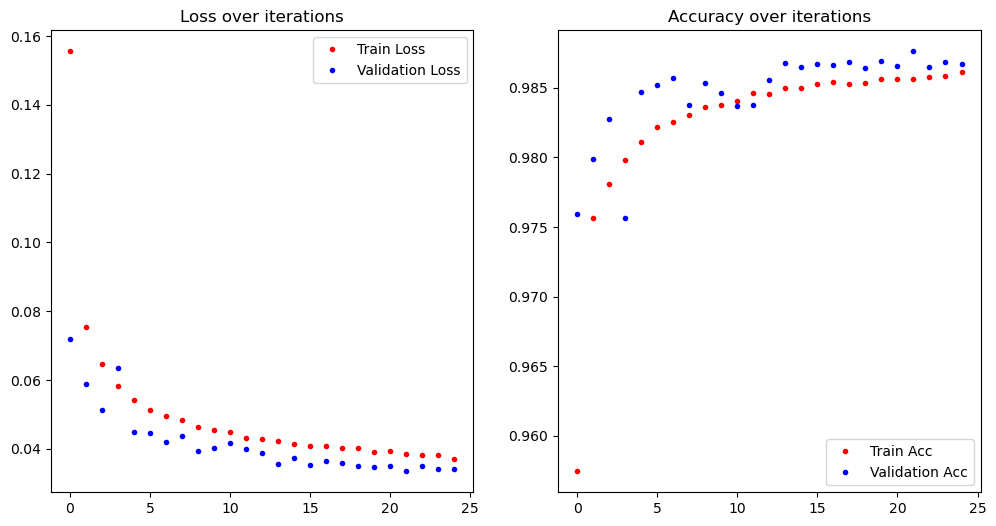

In [24]:
n = len(history.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (history.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (history.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (history.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (history.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

## With PCA Dimension Reduction

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Assuming your data is already scaled and suitable for LSTM
# Reshape input data to be 3D [samples, timesteps, features]
#let's assume 1 timestep and all features as different time points
X_train_reshaped = X_train_pca.reshape((X_train_pca.shape[0], 1, X_train_pca.shape[1]))
X_test_reshaped = X_test_pca.reshape((X_test_pca.shape[0], 1, X_test_pca.shape[1]))

# Design the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_train_pca.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=25, batch_size=256, validation_data=(X_test_reshaped, y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)
print("Test Accuracy:", accuracy)

Epoch 1/25
1927/1927 [==============================] - 12s 6ms/step - loss: 0.1451 - accuracy: 0.9639 - val_loss: 0.0705 - val_accuracy: 0.9766
Epoch 2/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0678 - accuracy: 0.9775 - val_loss: 0.0596 - val_accuracy: 0.9788
Epoch 3/25
1927/1927 [==============================] - 12s 6ms/step - loss: 0.0611 - accuracy: 0.9790 - val_loss: 0.0523 - val_accuracy: 0.9825
Epoch 4/25
1927/1927 [==============================] - 12s 6ms/step - loss: 0.0571 - accuracy: 0.9801 - val_loss: 0.0509 - val_accuracy: 0.9798
Epoch 5/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0541 - accuracy: 0.9809 - val_loss: 0.0488 - val_accuracy: 0.9831
Epoch 6/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0516 - accuracy: 0.9818 - val_loss: 0.0546 - val_accuracy: 0.9811
Epoch 7/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0506 - accuracy: 0.9821 - val_loss: 0.0462 - val_ac

Text(0.5, 1.0, 'Accuracy over iterations')

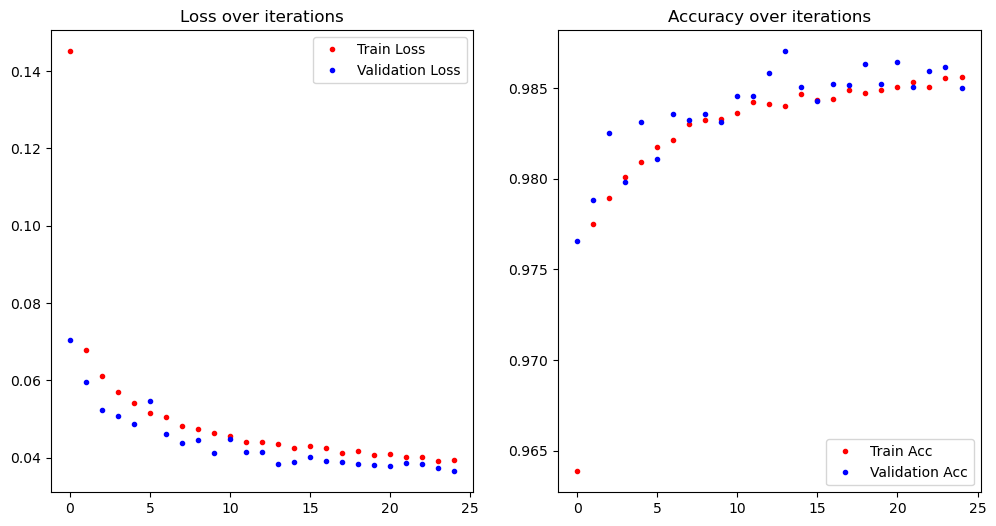

In [27]:
n = len(history.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (history.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (history.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (history.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (history.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

## With Autoencoder dimension reduction

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Assuming your data is already scaled and suitable for LSTM
# Reshape input data to be 3D [samples, timesteps, features]
#let's assume 1 timestep and all features as different time points
X_train_reshaped = X_train_encoded.reshape((X_train_encoded.shape[0], 1, X_train_encoded.shape[1]))
X_test_reshaped = X_test_encoded.reshape((X_test_encoded.shape[0], 1, X_test_encoded.shape[1]))

# Design the LSTM model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_train_encoded.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.003), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_encoded, epochs=25, batch_size=256, validation_data=(X_test_reshaped, y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(X_test_reshaped, y_test_encoded)
print("Test Accuracy:", accuracy)

Epoch 1/25
1927/1927 [==============================] - 13s 6ms/step - loss: 0.1489 - accuracy: 0.9568 - val_loss: 0.0850 - val_accuracy: 0.9720
Epoch 2/25
1927/1927 [==============================] - 12s 6ms/step - loss: 0.0899 - accuracy: 0.9704 - val_loss: 0.0760 - val_accuracy: 0.9741
Epoch 3/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0819 - accuracy: 0.9723 - val_loss: 0.0760 - val_accuracy: 0.9742
Epoch 4/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0764 - accuracy: 0.9741 - val_loss: 0.0663 - val_accuracy: 0.9773
Epoch 5/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0738 - accuracy: 0.9748 - val_loss: 0.0645 - val_accuracy: 0.9785
Epoch 6/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0714 - accuracy: 0.9753 - val_loss: 0.0621 - val_accuracy: 0.9788
Epoch 7/25
1927/1927 [==============================] - 11s 6ms/step - loss: 0.0692 - accuracy: 0.9763 - val_loss: 0.0600 - val_ac

Text(0.5, 1.0, 'Accuracy over iterations')

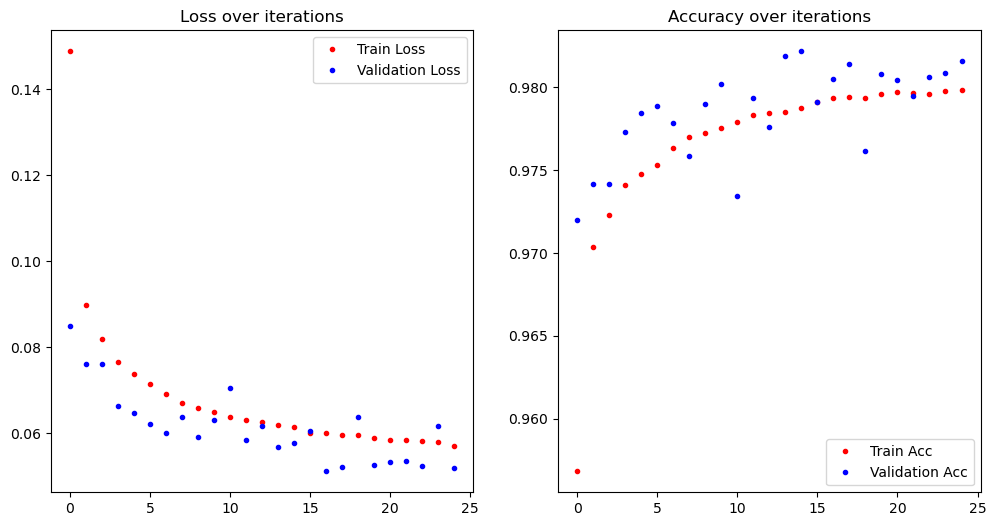

In [29]:
n = len(history.history["loss"])

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 2, 1)
ax.plot(range(n), (history.history["loss"]),'r.', label="Train Loss")
ax.plot(range(n), (history.history["val_loss"]),'b.', label="Validation Loss")
ax.legend()
ax.set_title('Loss over iterations')

ax = fig.add_subplot(1, 2, 2)
ax.plot(range(n), (history.history["accuracy"]),'r.', label="Train Acc")
ax.plot(range(n), (history.history["val_accuracy"]),'b.', label="Validation Acc")
ax.legend(loc='lower right')
ax.set_title('Accuracy over iterations')

<a id='5_3'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:70%"> <b>Unsupervised Autoencoder</b>

### Splitting Data for Autoencoder

In [17]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming df_scaled and df_experiment['Label'] are already defined

# Separate normal and anomalous data
normal_data = df_scaled[df_experiment['Label'] == 'Benign']
anomalous_data = df_scaled[df_experiment['Label'] != 'Benign']

# Reduce the size of normal down to 30% and have option to reduce anomalous (currently not downsizing)
normal_data_reduced = normal_data.sample(frac=0.3, random_state=42)
anomalous_data_reduced = anomalous_data.sample(frac=1, random_state=42)

# Delete the original datasets to free up memory
del normal_data, anomalous_data

# Split the normal data into training and test sets
X_train_normal, X_test_normal = train_test_split(normal_data_reduced, test_size=0.3, random_state=42)

# Split the anomalous data into test set (no training data needed for anomalies)
_, X_test_anomalies = train_test_split(anomalous_data_reduced, test_size=0.3, random_state=42)

# Delete the reduced datasets as they are no longer needed
del normal_data_reduced, anomalous_data_reduced


In [20]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in list(
                          locals().items())), key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))



                X_train_normal: 243.9 MiB
                             _: 138.4 MiB
                 X_test_normal: 104.5 MiB
              X_test_anomalies: 59.3 MiB
                            _9:  3.1 KiB
                            __:  1.8 KiB
                            _5:  1.8 KiB
                  MinMaxScaler:  1.4 KiB
                          _i13:  1.1 KiB
                          _i15:  1.1 KiB


In [19]:
import gc
del df_scaled
del dfu
del df
del df_experiment
gc.collect()

0

### Model

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# Define the autoencoder architecture
input_dim = X_train_normal.shape[1]
encoding_dim = 32  # This is a hyperparameter and can be tuned

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)

# Decoder
decoder = Dense(input_dim, activation='sigmoid')(encoder)

# Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(X_train_normal, X_train_normal,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test_normal, X_test_normal))

Epoch 1/50
1623/1623 [==============================] - 5s 2ms/step - loss: 0.0127 - val_loss: 7.7903e-04
Epoch 2/50
1623/1623 [==============================] - 4s 2ms/step - loss: 4.9456e-04 - val_loss: 2.9669e-04
Epoch 3/50
1623/1623 [==============================] - 4s 2ms/step - loss: 2.3920e-04 - val_loss: 1.9663e-04
Epoch 4/50
1623/1623 [==============================] - 4s 2ms/step - loss: 1.5516e-04 - val_loss: 1.3246e-04
Epoch 5/50
1623/1623 [==============================] - 4s 2ms/step - loss: 1.1347e-04 - val_loss: 1.0115e-04
Epoch 6/50
1623/1623 [==============================] - 4s 2ms/step - loss: 9.1101e-05 - val_loss: 8.3220e-05
Epoch 7/50
1623/1623 [==============================] - 4s 2ms/step - loss: 7.6431e-05 - val_loss: 7.0821e-05
Epoch 8/50
1623/1623 [==============================] - 4s 2ms/step - loss: 6.6430e-05 - val_loss: 6.4233e-05
Epoch 9/50
1623/1623 [==============================] - 4s 2ms/step - loss: 6.0078e-05 - val_loss: 5.7637e-05
Epoch 10/50
16

In [22]:
# Function to calculate reconstruction error
def calculate_reconstruction_error(data):
    predictions = autoencoder.predict(data)
    reconstruction_error = np.mean(np.power(data - predictions, 2), axis=1)
    return reconstruction_error

# Calculate reconstruction error for both normal and anomalous test data
error_normal = calculate_reconstruction_error(X_test_normal)
error_anomalies = calculate_reconstruction_error(X_test_anomalies)

3155/3155 [==============================] - 3s 853us/step


In [35]:
# Determine a threshold for anomaly detection
threshold = np.percentile(error_normal, 98.3)  # Optimal is between 98 and 99

# Classify as anomalies or normal based on the threshold
is_anomaly_normal = error_normal > threshold
is_anomaly_anomalous = error_anomalies > threshold

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

# Assuming true labels are 0 for normal and 1 for anomalies
y_true = np.concatenate([np.zeros(len(X_test_normal)), np.ones(len(X_test_anomalies))])
y_pred = np.concatenate([is_anomaly_normal.astype(int), is_anomaly_anomalous.astype(int)])

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_true, y_pred))

Accuracy: 0.8853847339794269
              precision    recall  f1-score   support

         0.0       0.86      0.98      0.92    177959
         1.0       0.96      0.71      0.82    100948

    accuracy                           0.89    278907
   macro avg       0.91      0.85      0.87    278907
weighted avg       0.89      0.89      0.88    278907



<a id='5_4'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:70%"> <b>Unsupervised Learning K Means</b>

In [28]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist
from sklearn.metrics import classification_report, confusion_matrix

# Assuming df_scaled is your scaled feature set

# Initialize K-Means
kmeans = KMeans(n_clusters=2, random_state=42)  # Adjust n_clusters based on domain knowledge or experimentation
kmeans.fit(df_scaled)

# Calculate distances to the nearest cluster center
distances = np.min(cdist(df_scaled, kmeans.cluster_centers_, 'euclidean'), axis=1)

# Determine the threshold for anomalies
threshold = np.percentile(distances, 78)  # This can be tuned

# Detect anomalies (points with distances above the threshold)
anomalies_kmeans = distances > threshold

# True labels (0 for 'Benign' and 1 for others)
true_labels = df_experiment['Label'].apply(lambda x: 0 if x == 'Benign' else 1).values

# Calculate accuracy
accuracy_kmeans = accuracy_score(true_labels, anomalies_kmeans)
print("Accuracy:", accuracy_kmeans)

# Print the classification report for precision, recall, and F1-score
print(classification_report(true_labels, anomalies_kmeans))

# Print the confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, anomalies_kmeans))

C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Accuracy: 0.7915135642079514
              precision    recall  f1-score   support

           0       0.91      0.83      0.87   1977318
           1       0.36      0.54      0.43    336492

    accuracy                           0.79   2313810
   macro avg       0.64      0.69      0.65   2313810
weighted avg       0.83      0.79      0.81   2313810

Confusion Matrix:
[[1649846  327472]
 [ 154926  181566]]


<a id='5_5'></a>
# <p style="padding: 10px;color:white; display:fill;background-color:#303090; border-radius:5px; font-size:70%"> <b>Deep Q Learning</b>

In [16]:
import tensorflow as tf
import numpy as np
import gym
from gym import spaces
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from collections import deque
import random


# Custom environment for the classification task
class ClassificationEnv(gym.Env):
    def __init__(self, X_train, y_train, n_actions):
        super(ClassificationEnv, self).__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.n_actions = n_actions
        self.n_features = X_train.shape[1]
        
        # Define action and observation space
        self.action_space = spaces.Discrete(self.n_actions)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.n_features,), dtype=np.float32)
    
    def reset(self):
        # Reset the state to a random sample from the dataset
        self.current_index = np.random.randint(0, len(self.X_train))
        self.current_state = self.X_train[self.current_index]
        return self.current_state
    
    def step(self, action):
        # Check if the action is correct
        correct_action = self.y_train[self.current_index]
        reward = 1 if action == correct_action else 0
        done = True  # Each step is a new episode in this case
        
        # Select a new random state for the next step
        self.current_index = np.random.randint(0, len(self.X_train))
        self.current_state = self.X_train[self.current_index]
        
        return self.current_state, reward, done, {}

In [17]:
import tensorflow as tf

# Define the DQN model
def build_model(input_shape, n_actions):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,)),
        Dense(128, activation='relu'),
        Dense(n_actions, activation='linear')  # No activation in the last layer
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
    return model

In [18]:
# Experience Replay Buffer
class ReplayBuffer:
    def __init__(self, max_size):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

In [29]:
# Main DQL training loop
def train_dql(env, episodes=3000, batch_size=1024, gamma=0.001, epsilon=0.95, epsilon_min=0.01, epsilon_decay=0.998):
    input_shape = env.observation_space.shape[0]
    n_actions = env.action_space.n
    model = build_model(input_shape, n_actions)
    replay_buffer = ReplayBuffer(max_size=10000)
    
    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, input_shape])
        done = False
        total_reward = 0
        
        while not done:
            if np.random.rand() <= epsilon:
                action = env.action_space.sample()  # Explore
            else:
                q_values = model.predict(state)
                action = np.argmax(q_values[0])  # Exploit
                
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, input_shape])
            
            replay_buffer.add((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            
            if len(replay_buffer.buffer) > batch_size:
                minibatch = replay_buffer.sample(batch_size)
                states = np.array([i[0] for i in minibatch]).reshape(batch_size, input_shape)
                actions = np.array([i[1] for i in minibatch])
                rewards = np.array([i[2] for i in minibatch])
                next_states = np.array([i[3] for i in minibatch]).reshape(batch_size, input_shape)
                dones = np.array([i[4] for i in minibatch])
                
                # Predict the Q-values for the next states
                next_q_values = model.predict_on_batch(next_states)
                # Compute the maximum Q-value for each next state
                max_next_q_values = np.max(next_q_values, axis=1)
                
                # Compute the target Q-values
                target_q = rewards + (gamma * max_next_q_values * (1 - dones))
                
                # Get the current predictions for all actions
                q_values = model.predict_on_batch(states)
                # Update the Q-values for the actions taken
                q_values[np.arange(batch_size), actions] = target_q
                
                # Fit the model
                model.fit(states, q_values, epochs=1, verbose=0, batch_size=batch_size)
        
        # Update epsilon
        epsilon = max(epsilon_min, epsilon_decay*epsilon)
        
        print(f'Episode: {episode+1}, Total reward: {total_reward}, Epsilon: {epsilon}')
    
    return model

In [20]:
def train_ddqn(env, episodes, batch_size, gamma, epsilon, epsilon_min, epsilon_decay):
    input_shape = env.observation_space.shape[0]
    n_actions = env.action_space.n
    model = build_model(input_shape, n_actions)  # Current Q-network
    target_model = build_model(input_shape, n_actions)  # Target Q-network
    target_model.set_weights(model.get_weights())  # Initialize target network weights to match model's weights
    
    replay_buffer = ReplayBuffer(max_size=10000)
    
    for episode in range(episodes):
        state = env.reset()
        state = np.reshape(state, [1, input_shape])
        done = False
        total_reward = 0
        
        while not done:
            if np.random.rand() <= epsilon:
                action = env.action_space.sample()  # Explore
            else:
                q_values = model.predict(state)
                action = np.argmax(q_values[0])  # Exploit
                
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, [1, input_shape])
            
            replay_buffer.add((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            
            if len(replay_buffer.buffer) > batch_size:
                minibatch = replay_buffer.sample(batch_size)
                states = np.array([i[0] for i in minibatch]).reshape(batch_size, input_shape)
                actions = np.array([i[1] for i in minibatch])
                rewards = np.array([i[2] for i in minibatch])
                next_states = np.array([i[3] for i in minibatch]).reshape(batch_size, input_shape)
                dones = np.array([i[4] for i in minibatch])
                
                # Corrected reshaping for states and next_states here
                
                # Predict the Q-values of next states with the current model
                next_q_values = model.predict_on_batch(next_states)
                # Select the actions with the highest Q-value
                max_action_next = np.argmax(next_q_values, axis=1)
                # Evaluate the selected actions with the target network
                next_q_values_target = target_model.predict_on_batch(next_states)
                # Use the Q-values from the target network for the selected actions
                max_q_values_next = next_q_values_target[np.arange(batch_size), max_action_next]
                
                # Compute the target Q-values
                target_q = rewards + (gamma * max_q_values_next * (1 - dones))
                
                # Get the current predictions and update them with the target Q-values for the taken actions
                q_values = model.predict_on_batch(states)
                q_values[np.arange(batch_size), actions] = target_q
                
                # Train the model on the states and the updated Q-values
                model.fit(states, q_values, epochs=1, verbose=0, batch_size=batch_size)
        
        # Update epsilon
        epsilon = max(epsilon_min, epsilon_decay*epsilon)
        
        # Periodically update the target network weights
        if episode % 10 == 0:
            target_model.set_weights(model.get_weights())
        
        print(f'Episode: {episode+1}, Total reward: {total_reward}, Epsilon: {epsilon}')
    
    return model

In [21]:
def predict_classes_batch(model, X, env, batch_size=12000):
    # Prepare batches
    num_samples = len(X)
    predictions = np.zeros(num_samples, dtype=int)  # Initialize predictions array
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch = np.reshape(X[start:end], (end-start, env.n_features))
        q_values = model.predict(batch)
        predicted_classes = np.argmax(q_values, axis=1)
        predictions[start:end] = predicted_classes
    return predictions

## No Dimension Reduction and ADASYN

In [22]:
#X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.3, random_state=42)
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.fit_transform(y_test)

In [30]:
X_train_np = X_train.values
env = ClassificationEnv(X_train_np, y_train_encoded, len(np.unique(y_train_encoded)))
#env = ClassificationEnv(X_train_encoded_resampled, y_train_resampled, len(np.unique(y_train_encoded)))
model = train_dql(env)


Episode: 1, Total reward: 0, Epsilon: 0.8982
Episode: 2, Total reward: 0, Epsilon: 0.8964036
Episode: 3, Total reward: 0, Epsilon: 0.8946107928
Episode: 4, Total reward: 0, Epsilon: 0.8928215712144
Episode: 5, Total reward: 0, Epsilon: 0.8910359280719712
Episode: 6, Total reward: 0, Epsilon: 0.8892538562158272
Episode: 7, Total reward: 0, Epsilon: 0.8874753485033955
Episode: 8, Total reward: 0, Epsilon: 0.8857003978063887
Episode: 9, Total reward: 0, Epsilon: 0.8839289970107759
1/1 [==============================] - 0s 41ms/step
Episode: 10, Total reward: 0, Epsilon: 0.8821611390167543
Episode: 11, Total reward: 0, Epsilon: 0.8803968167387208
Episode: 12, Total reward: 0, Epsilon: 0.8786360231052434
1/1 [==============================] - 0s 18ms/step
Episode: 13, Total reward: 0, Epsilon: 0.8768787510590329
Episode: 14, Total reward: 0, Epsilon: 0.8751249935569149
Episode: 15, Total reward: 0, Epsilon: 0.873374743569801
Episode: 16, Total reward: 0, Epsilon: 0.8716279940826615
Episode:

In [31]:
import numpy as np
from sklearn.metrics import classification_report

# Convert X_test to numpy array if not already
X_test_np = X_test.values


# Predict classes on the test set using batch predictions
y_pred = predict_classes_batch(model, X_test_np, env)
#y_pred = predict_classes_batch(model, X_test_encoded_resampled, env)

# Decode the predicted labels to original labels if necessary
# y_pred_decoded = label_encoder.inverse_transform(y_pred) # Uncomment if you need the original labels

# Generate classification report
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

230/230 [==============================] - 0s 871us/step
              precision    recall  f1-score   support

      Benign       0.92      0.99      0.96    177785
         Bot       0.00      0.00      0.00       423
 Brute Force       0.00      0.00      0.00      2740
        DDoS       0.82      0.46      0.59     11585
         DoS       0.93      0.72      0.81     17545
  Heartbleed       0.00      0.00      0.00         5
Infiltration       0.00      0.00      0.00         7
    PortScan       0.00      0.00      0.00       559
  Web Attack       0.00      0.00      0.00       688

    accuracy                           0.92    211337
   macro avg       0.30      0.24      0.26    211337
weighted avg       0.90      0.92      0.91    211337



C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [26]:
import optuna
from sklearn.metrics import accuracy_score

X_train_np = X_train.values
X_test_np = X_test.values


def objective(trial):
    # Define the hyperparameters to tune
    batch_size = trial.suggest_categorical('batch_size', [64, 256, 512, 1024])
    gamma = trial.suggest_float('gamma', 0.001, 0.9999, log=True)
    epsilon = trial.suggest_float('epsilon', 0.8, 1.0)
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.990, 0.999, log=True)
    epsilon_min = trial.suggest_float('epsilon_min', 0.001, 0.01)

    # Run the training algorithm with the suggested hyperparameters
    env = ClassificationEnv(X_train_np, y_train_encoded, len(np.unique(y_train_encoded)))
    model = train_ddqn(env, episodes=1000, batch_size=batch_size, gamma=gamma, epsilon=epsilon, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay)
    
    # Predict classes on the validation or test set
    y_pred = predict_classes_batch(model, X_test_np, env)
    
    # Calculate and return the accuracy
    accuracy = accuracy_score(y_test_encoded, y_pred)
    return accuracy

C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)  # Adjust the number of trials based on computational resources

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-08 00:29:56,630] A new study created in memory with name: no-name-eea7a2a6-24ab-4eec-b128-0544b9c9c812


Episode: 1, Total reward: 0, Epsilon: 0.7973499867174146
Episode: 2, Total reward: 0, Epsilon: 0.7939745037663565
1/1 [==============================] - 0s 37ms/step
Episode: 3, Total reward: 1, Epsilon: 0.790613310506579
1/1 [==============================] - 0s 14ms/step
Episode: 4, Total reward: 0, Epsilon: 0.7872663464444344
Episode: 5, Total reward: 0, Epsilon: 0.7839335513423673
Episode: 6, Total reward: 0, Epsilon: 0.7806148652178305
Episode: 7, Total reward: 0, Epsilon: 0.7773102283422056
1/1 [==============================] - 0s 14ms/step
Episode: 8, Total reward: 0, Epsilon: 0.7740195812397279
1/1 [==============================] - 0s 14ms/step
Episode: 9, Total reward: 0, Epsilon: 0.7707428646864161
1/1 [==============================] - 0s 14ms/step
Episode: 10, Total reward: 0, Epsilon: 0.7674800197090061
Episode: 11, Total reward: 0, Epsilon: 0.7642309875838903
Episode: 12, Total reward: 0, Epsilon: 0.7609957098360598
Episode: 13, Total reward: 0, Epsilon: 0.7577741282380

[I 2024-02-08 00:31:10,910] Trial 0 finished with value: 0.9301494769018203 and parameters: {'batch_size': 512, 'gamma': 0.26129518176255273, 'epsilon': 0.8007398201105825, 'epsilon_decay': 0.9957666231801738, 'epsilon_min': 0.005794613497137279}. Best is trial 0 with value: 0.9301494769018203.


1/1 [==============================] - 0s 41ms/step
Episode: 1, Total reward: 0, Epsilon: 0.8558487043741844
Episode: 2, Total reward: 1, Epsilon: 0.8541625851238364
Episode: 3, Total reward: 0, Epsilon: 0.852479787720109
Episode: 4, Total reward: 0, Epsilon: 0.8508003056185868
Episode: 5, Total reward: 0, Epsilon: 0.8491241322877473
Episode: 6, Total reward: 0, Epsilon: 0.8474512612089363
1/1 [==============================] - 0s 15ms/step
Episode: 7, Total reward: 0, Epsilon: 0.8457816858763418
Episode: 8, Total reward: 0, Epsilon: 0.8441153997969691
Episode: 9, Total reward: 0, Epsilon: 0.8424523964906153
Episode: 10, Total reward: 0, Epsilon: 0.8407926694898444
Episode: 11, Total reward: 0, Epsilon: 0.8391362123399619
1/1 [==============================] - 0s 16ms/step
Episode: 12, Total reward: 0, Epsilon: 0.8374830185989898
Episode: 13, Total reward: 0, Epsilon: 0.8358330818376414
Episode: 14, Total reward: 0, Epsilon: 0.8341863956392966
Episode: 15, Total reward: 0, Epsilon: 0.8

[I 2024-02-08 00:31:46,038] Trial 1 finished with value: 0.02134032374832613 and parameters: {'batch_size': 1024, 'gamma': 0.002054564714385978, 'epsilon': 0.8575381520284873, 'epsilon_decay': 0.9980298863084908, 'epsilon_min': 0.007229668392747589}. Best is trial 0 with value: 0.9301494769018203.


Episode: 1, Total reward: 0, Epsilon: 0.9234754981042362
Episode: 2, Total reward: 0, Epsilon: 0.9200378508516589
Episode: 3, Total reward: 1, Epsilon: 0.9166130002771281
Episode: 4, Total reward: 0, Epsilon: 0.9132008987448754
Episode: 5, Total reward: 0, Epsilon: 0.9098014987964568
Episode: 6, Total reward: 0, Epsilon: 0.9064147531500928
Episode: 7, Total reward: 0, Epsilon: 0.903040614700011
Episode: 8, Total reward: 1, Epsilon: 0.8996790365157906
Episode: 9, Total reward: 0, Epsilon: 0.8963299718417099
Episode: 10, Total reward: 0, Epsilon: 0.8929933740960959
Episode: 11, Total reward: 0, Epsilon: 0.8896691968706762
Episode: 12, Total reward: 0, Epsilon: 0.8863573939299338
Episode: 13, Total reward: 0, Epsilon: 0.883057919210464
1/1 [==============================] - 0s 38ms/step
Episode: 14, Total reward: 0, Epsilon: 0.8797707268203332
1/1 [==============================] - 0s 14ms/step
Episode: 15, Total reward: 0, Epsilon: 0.8764957710384415
Episode: 16, Total reward: 0, Epsilon

[I 2024-02-08 00:33:24,291] Trial 2 finished with value: 0.9390783440665856 and parameters: {'batch_size': 64, 'gamma': 0.01564878349247279, 'epsilon': 0.926925989848616, 'epsilon_decay': 0.9962774894844159, 'epsilon_min': 0.009782617931268642}. Best is trial 2 with value: 0.9390783440665856.


1/1 [==============================] - 0s 36ms/step
Episode: 1, Total reward: 0, Epsilon: 0.922842906207908
Episode: 2, Total reward: 0, Epsilon: 0.9156511485476314
Episode: 3, Total reward: 0, Epsilon: 0.9085154365890622
Episode: 4, Total reward: 0, Epsilon: 0.9014353335654421
Episode: 5, Total reward: 0, Epsilon: 0.8944104061137566
Episode: 6, Total reward: 0, Epsilon: 0.8874402242482088
Episode: 7, Total reward: 0, Epsilon: 0.8805243613339017
Episode: 8, Total reward: 0, Epsilon: 0.8736623940607235
Episode: 9, Total reward: 0, Epsilon: 0.8668539024174381
Episode: 10, Total reward: 1, Epsilon: 0.8600984696659761
Episode: 11, Total reward: 0, Epsilon: 0.8533956823159276
Episode: 12, Total reward: 0, Epsilon: 0.8467451300992322
Episode: 13, Total reward: 0, Epsilon: 0.8401464059450682
Episode: 14, Total reward: 0, Epsilon: 0.8335991059549352
Episode: 15, Total reward: 0, Epsilon: 0.827102829377933
Episode: 16, Total reward: 0, Epsilon: 0.8206571785862314
Episode: 17, Total reward: 0, E

[I 2024-02-08 00:34:41,287] Trial 3 finished with value: 0.9331446930731486 and parameters: {'batch_size': 512, 'gamma': 0.005104603461944635, 'epsilon': 0.9300911497671278, 'epsilon_decay': 0.9922069535216687, 'epsilon_min': 0.00648129956706591}. Best is trial 2 with value: 0.9390783440665856.


Episode: 1, Total reward: 0, Epsilon: 0.9627968131566362
Episode: 2, Total reward: 0, Epsilon: 0.957430813680255
Episode: 3, Total reward: 0, Epsilon: 0.9520947207739693
Episode: 4, Total reward: 0, Epsilon: 0.9467883677581255
Episode: 5, Total reward: 0, Epsilon: 0.9415115888820331
Episode: 6, Total reward: 0, Epsilon: 0.9362642193187877
Episode: 7, Total reward: 0, Epsilon: 0.9310460951601218
Episode: 8, Total reward: 0, Epsilon: 0.9258570534112858
Episode: 9, Total reward: 0, Epsilon: 0.9206969319859559
Episode: 10, Total reward: 0, Epsilon: 0.9155655697011716
Episode: 11, Total reward: 1, Epsilon: 0.9104628062723007
Episode: 12, Total reward: 0, Epsilon: 0.9053884823080325
Episode: 13, Total reward: 1, Epsilon: 0.9003424393053994
1/1 [==============================] - 0s 38ms/step
Episode: 14, Total reward: 0, Epsilon: 0.8953245196448254
Episode: 15, Total reward: 0, Epsilon: 0.8903345665852033
Episode: 16, Total reward: 0, Epsilon: 0.8853724242589978
1/1 [=========================

[I 2024-02-08 00:36:12,802] Trial 4 finished with value: 0.9542531596454951 and parameters: {'batch_size': 256, 'gamma': 0.001695446707259995, 'epsilon': 0.9681928868169367, 'epsilon_decay': 0.9944266543022839, 'epsilon_min': 0.004856911597248329}. Best is trial 4 with value: 0.9542531596454951.


Episode: 1, Total reward: 0, Epsilon: 0.9461624557077657
Episode: 2, Total reward: 0, Epsilon: 0.9382460682319117
Episode: 3, Total reward: 0, Epsilon: 0.9303959158833234
Episode: 4, Total reward: 0, Epsilon: 0.922611444483457
Episode: 5, Total reward: 0, Epsilon: 0.9148921044904904
Episode: 6, Total reward: 0, Epsilon: 0.9072373509605287
1/1 [==============================] - 0s 37ms/step
Episode: 7, Total reward: 0, Epsilon: 0.8996466435091339
1/1 [==============================] - 0s 14ms/step
Episode: 8, Total reward: 0, Epsilon: 0.8921194462731769
Episode: 9, Total reward: 0, Epsilon: 0.8846552278730081
Episode: 10, Total reward: 0, Epsilon: 0.8772534613749452
Episode: 11, Total reward: 0, Epsilon: 0.8699136242540744
Episode: 12, Total reward: 0, Epsilon: 0.8626351983573627
Episode: 13, Total reward: 0, Epsilon: 0.8554176698670796
Episode: 14, Total reward: 0, Epsilon: 0.8482605292645238
Episode: 15, Total reward: 0, Epsilon: 0.8411632712940542
Episode: 16, Total reward: 0, Epsilo

[I 2024-02-08 00:38:02,473] Trial 5 finished with value: 0.9400625541197235 and parameters: {'batch_size': 64, 'gamma': 0.036655654108441973, 'epsilon': 0.9541456371652731, 'epsilon_decay': 0.9916331625419101, 'epsilon_min': 0.005108134046750003}. Best is trial 4 with value: 0.9542531596454951.


Episode: 1, Total reward: 0, Epsilon: 0.9797021550800609
Episode: 2, Total reward: 0, Epsilon: 0.9701177990597544
Episode: 3, Total reward: 0, Epsilon: 0.9606272061079965
Episode: 4, Total reward: 0, Epsilon: 0.9512294589474025
Episode: 5, Total reward: 0, Epsilon: 0.9419236492742469
Episode: 6, Total reward: 0, Epsilon: 0.9327088776706742
Episode: 7, Total reward: 0, Epsilon: 0.9235842535177696
Episode: 8, Total reward: 0, Epsilon: 0.9145488949094792
Episode: 9, Total reward: 0, Epsilon: 0.9056019285673729
Episode: 10, Total reward: 1, Epsilon: 0.8967424897562409
Episode: 11, Total reward: 0, Epsilon: 0.8879697222005163
Episode: 12, Total reward: 0, Epsilon: 0.8792827780015143
Episode: 13, Total reward: 0, Epsilon: 0.8706808175554827
Episode: 14, Total reward: 0, Epsilon: 0.8621630094724523
Episode: 15, Total reward: 0, Epsilon: 0.8537285304958825
Episode: 16, Total reward: 0, Epsilon: 0.8453765654230926
Episode: 17, Total reward: 0, Epsilon: 0.8371063070264713
Episode: 18, Total rewa

[I 2024-02-08 00:39:50,621] Trial 6 finished with value: 0.9319002351694213 and parameters: {'batch_size': 64, 'gamma': 0.04653124106619038, 'epsilon': 0.9893812005086156, 'epsilon_decay': 0.9902170716165024, 'epsilon_min': 0.007103802263066939}. Best is trial 4 with value: 0.9542531596454951.


Episode: 1, Total reward: 0, Epsilon: 0.9353159039129615
Episode: 2, Total reward: 0, Epsilon: 0.9300375256719758
Episode: 3, Total reward: 0, Epsilon: 0.924788935523696
Episode: 4, Total reward: 0, Epsilon: 0.9195699653614751
1/1 [==============================] - 0s 39ms/step
Episode: 5, Total reward: 0, Epsilon: 0.9143804480273621
Episode: 6, Total reward: 0, Epsilon: 0.9092202173067483
Episode: 7, Total reward: 0, Epsilon: 0.9040891079230435
Episode: 8, Total reward: 0, Epsilon: 0.8989869555323822
1/1 [==============================] - 0s 14ms/step
Episode: 9, Total reward: 1, Epsilon: 0.8939135967183599
Episode: 10, Total reward: 0, Epsilon: 0.8888688689867993
Episode: 11, Total reward: 1, Epsilon: 0.8838526107605454
Episode: 12, Total reward: 0, Epsilon: 0.8788646613742909
Episode: 13, Total reward: 0, Epsilon: 0.8739048610694294
1/1 [==============================] - 0s 15ms/step
Episode: 14, Total reward: 0, Epsilon: 0.8689730509889396
1/1 [==============================] - 0s 

[I 2024-02-08 00:40:35,112] Trial 7 finished with value: 0.5729096182873799 and parameters: {'batch_size': 1024, 'gamma': 0.0014133186009349821, 'epsilon': 0.9406242393073799, 'epsilon_decay': 0.994356582392213, 'epsilon_min': 0.0027588794481587364}. Best is trial 4 with value: 0.9542531596454951.


Episode: 1, Total reward: 0, Epsilon: 0.7999032792817036
Episode: 2, Total reward: 0, Epsilon: 0.7936472000714628
Episode: 3, Total reward: 0, Epsilon: 0.7874400499356472
Episode: 4, Total reward: 0, Epsilon: 0.7812814461977841
Episode: 5, Total reward: 0, Epsilon: 0.7751710091743306
Episode: 6, Total reward: 0, Epsilon: 0.769108362151266
Episode: 7, Total reward: 0, Epsilon: 0.7630931313608665
Episode: 8, Total reward: 0, Epsilon: 0.7571249459586625
Episode: 9, Total reward: 0, Epsilon: 0.7512034380005754
Episode: 10, Total reward: 0, Epsilon: 0.7453282424202337
Episode: 11, Total reward: 0, Epsilon: 0.7394989970064662
Episode: 12, Total reward: 0, Epsilon: 0.7337153423809715
Episode: 13, Total reward: 0, Epsilon: 0.7279769219761619
1/1 [==============================] - 0s 38ms/step
Episode: 14, Total reward: 0, Epsilon: 0.7222833820131808
Episode: 15, Total reward: 1, Epsilon: 0.7166343714800915
Episode: 16, Total reward: 1, Epsilon: 0.7110295421102376
Episode: 17, Total reward: 0, 

[I 2024-02-08 00:42:12,905] Trial 8 finished with value: 0.948106578592485 and parameters: {'batch_size': 256, 'gamma': 0.4143738120870808, 'epsilon': 0.806208673259364, 'epsilon_decay': 0.9921789554158866, 'epsilon_min': 0.0047170515688598185}. Best is trial 4 with value: 0.9542531596454951.


Episode: 1, Total reward: 0, Epsilon: 0.9191660401326781
Episode: 2, Total reward: 0, Epsilon: 0.9132556262934618
Episode: 3, Total reward: 0, Epsilon: 0.9073832175482389
Episode: 4, Total reward: 0, Epsilon: 0.9015485695169696
Episode: 5, Total reward: 0, Epsilon: 0.8957514393910245
1/1 [==============================] - 0s 38ms/step
Episode: 6, Total reward: 1, Epsilon: 0.8899915859230805
Episode: 7, Total reward: 0, Epsilon: 0.8842687694170805
Episode: 8, Total reward: 0, Epsilon: 0.8785827517182597
Episode: 9, Total reward: 0, Epsilon: 0.8729332962032336
Episode: 10, Total reward: 1, Epsilon: 0.8673201677701514
Episode: 11, Total reward: 0, Epsilon: 0.8617431328289126
Episode: 12, Total reward: 0, Epsilon: 0.8562019592914455
1/1 [==============================] - 0s 17ms/step
Episode: 13, Total reward: 0, Epsilon: 0.8506964165620494
1/1 [==============================] - 0s 16ms/step
Episode: 14, Total reward: 0, Epsilon: 0.845226275527798
Episode: 15, Total reward: 0, Epsilon: 0.8

[I 2024-02-08 00:44:02,280] Trial 9 finished with value: 0.9289286778936012 and parameters: {'batch_size': 64, 'gamma': 0.4955223404980437, 'epsilon': 0.925114705027508, 'epsilon_decay': 0.9935698083032276, 'epsilon_min': 0.00481134551918584}. Best is trial 4 with value: 0.9542531596454951.


Episode: 1, Total reward: 0, Epsilon: 0.9950851894606978
Episode: 2, Total reward: 1, Epsilon: 0.9925627855012671
Episode: 3, Total reward: 1, Epsilon: 0.9900467754886079
Episode: 4, Total reward: 1, Epsilon: 0.9875371432149455
Episode: 5, Total reward: 0, Epsilon: 0.9850338725135894
Episode: 6, Total reward: 0, Epsilon: 0.9825369472588299
Episode: 7, Total reward: 0, Epsilon: 0.9800463513658332
Episode: 8, Total reward: 0, Epsilon: 0.9775620687905388
Episode: 9, Total reward: 0, Epsilon: 0.9750840835295553
Episode: 10, Total reward: 0, Epsilon: 0.9726123796200581
Episode: 11, Total reward: 0, Epsilon: 0.9701469411396858
Episode: 12, Total reward: 0, Epsilon: 0.9676877522064382
Episode: 13, Total reward: 0, Epsilon: 0.9652347969785737
Episode: 14, Total reward: 0, Epsilon: 0.9627880596545074
Episode: 15, Total reward: 0, Epsilon: 0.9603475244727092
Episode: 16, Total reward: 0, Epsilon: 0.9579131757116024
Episode: 17, Total reward: 0, Epsilon: 0.955484997689462
Episode: 18, Total rewar

[I 2024-02-08 00:45:29,850] Trial 10 finished with value: 0.9485371704907328 and parameters: {'batch_size': 256, 'gamma': 0.00602477387567311, 'epsilon': 0.9976140036158637, 'epsilon_decay': 0.9974651376724863, 'epsilon_min': 0.0011737771857645487}. Best is trial 4 with value: 0.9542531596454951.


Episode: 1, Total reward: 1, Epsilon: 0.9974349465357241
Episode: 2, Total reward: 0, Epsilon: 0.9961910706788267
Episode: 3, Total reward: 0, Epsilon: 0.9949487460280033
Episode: 4, Total reward: 0, Epsilon: 0.9937079706487839
Episode: 5, Total reward: 0, Epsilon: 0.9924687426091112
Episode: 6, Total reward: 0, Epsilon: 0.9912310599793372
Episode: 7, Total reward: 0, Epsilon: 0.9899949208322205
Episode: 8, Total reward: 0, Epsilon: 0.9887603232429228
Episode: 9, Total reward: 0, Epsilon: 0.9875272652890066
Episode: 10, Total reward: 0, Epsilon: 0.9862957450504315
Episode: 11, Total reward: 0, Epsilon: 0.9850657606095516
Episode: 12, Total reward: 0, Epsilon: 0.9838373100511126
Episode: 13, Total reward: 0, Epsilon: 0.9826103914622485
Episode: 14, Total reward: 0, Epsilon: 0.9813850029324788
Episode: 15, Total reward: 0, Epsilon: 0.9801611425537056
Episode: 16, Total reward: 0, Epsilon: 0.9789388084202104
Episode: 17, Total reward: 0, Epsilon: 0.9777179986286516
Episode: 18, Total rewa

[I 2024-02-08 00:46:48,277] Trial 11 finished with value: 0.9578587753209329 and parameters: {'batch_size': 256, 'gamma': 0.006706858595163774, 'epsilon': 0.9986803755355805, 'epsilon_decay': 0.9987529253298999, 'epsilon_min': 0.0011097997193887296}. Best is trial 11 with value: 0.9578587753209329.


Episode: 1, Total reward: 0, Epsilon: 0.9721107340930112
Episode: 2, Total reward: 0, Epsilon: 0.9681393345388237
Episode: 3, Total reward: 0, Epsilon: 0.9641841594885594
Episode: 4, Total reward: 0, Epsilon: 0.9602451426596585
Episode: 5, Total reward: 0, Epsilon: 0.9563222180403482
Episode: 6, Total reward: 0, Epsilon: 0.9524153198885358
Episode: 7, Total reward: 0, Epsilon: 0.948524382730707
Episode: 8, Total reward: 1, Epsilon: 0.9446493413608292
1/1 [==============================] - 0s 38ms/step
Episode: 9, Total reward: 0, Epsilon: 0.9407901308392582
Episode: 10, Total reward: 0, Epsilon: 0.93694668649165
Episode: 11, Total reward: 0, Epsilon: 0.9331189439078773
Episode: 12, Total reward: 0, Epsilon: 0.9293068389409497
Episode: 13, Total reward: 0, Epsilon: 0.9255103077059388
Episode: 14, Total reward: 0, Epsilon: 0.9217292865789077
Episode: 15, Total reward: 0, Epsilon: 0.9179637121958449
Episode: 16, Total reward: 0, Epsilon: 0.914213521451602
Episode: 17, Total reward: 0, Eps

[I 2024-02-08 00:48:23,337] Trial 12 finished with value: 0.9377487141390292 and parameters: {'batch_size': 256, 'gamma': 0.005269297737025917, 'epsilon': 0.9760984247055787, 'epsilon_decay': 0.995914663407258, 'epsilon_min': 0.0010006008627836444}. Best is trial 11 with value: 0.9578587753209329.


Episode: 1, Total reward: 0, Epsilon: 0.8932982428619995
Episode: 2, Total reward: 0, Epsilon: 0.8920646544806513
Episode: 3, Total reward: 0, Epsilon: 0.8908327696068458
Episode: 4, Total reward: 0, Epsilon: 0.8896025858881467
Episode: 5, Total reward: 0, Epsilon: 0.8883741009753665
Episode: 6, Total reward: 0, Epsilon: 0.8871473125225617
Episode: 7, Total reward: 0, Epsilon: 0.8859222181870283
Episode: 8, Total reward: 0, Epsilon: 0.8846988156292975
Episode: 9, Total reward: 0, Epsilon: 0.8834771025131312
Episode: 10, Total reward: 0, Epsilon: 0.8822570765055173
Episode: 11, Total reward: 0, Epsilon: 0.8810387352766657
Episode: 12, Total reward: 0, Epsilon: 0.8798220765000033
Episode: 13, Total reward: 0, Epsilon: 0.8786070978521703
Episode: 14, Total reward: 0, Epsilon: 0.8773937970130148
Episode: 15, Total reward: 1, Epsilon: 0.8761821716655892
Episode: 16, Total reward: 0, Epsilon: 0.8749722194961455
Episode: 17, Total reward: 0, Epsilon: 0.8737639381941306
Episode: 18, Total rewa

[I 2024-02-08 00:49:47,786] Trial 13 finished with value: 0.9494882580901594 and parameters: {'batch_size': 256, 'gamma': 0.0011258637558839595, 'epsilon': 0.8945335371065798, 'epsilon_decay': 0.998619063239847, 'epsilon_min': 0.0031162263821035126}. Best is trial 11 with value: 0.9578587753209329.


Episode: 1, Total reward: 1, Epsilon: 0.967158399246846
Episode: 2, Total reward: 0, Epsilon: 0.9610416683186672
Episode: 3, Total reward: 0, Epsilon: 0.9549636222608022
Episode: 4, Total reward: 0, Epsilon: 0.9489240164132833
Episode: 5, Total reward: 0, Epsilon: 0.9429226076634789
Episode: 6, Total reward: 0, Epsilon: 0.9369591544363078
Episode: 7, Total reward: 0, Epsilon: 0.9310334166845148
Episode: 8, Total reward: 0, Epsilon: 0.9251451558790077
Episode: 9, Total reward: 0, Epsilon: 0.9192941349992566
Episode: 10, Total reward: 0, Epsilon: 0.9134801185237525
Episode: 11, Total reward: 0, Epsilon: 0.907702872420527
Episode: 12, Total reward: 0, Epsilon: 0.9019621641377318
Episode: 13, Total reward: 0, Epsilon: 0.8962577625942776
Episode: 14, Total reward: 0, Epsilon: 0.8905894381705328
Episode: 15, Total reward: 0, Epsilon: 0.8849569626990803
Episode: 16, Total reward: 0, Epsilon: 0.8793601094555331
Episode: 17, Total reward: 0, Epsilon: 0.8737986531494079
Episode: 18, Total reward

[I 2024-02-08 00:51:30,135] Trial 14 finished with value: 0.9378812039538746 and parameters: {'batch_size': 256, 'gamma': 0.010472767632023858, 'epsilon': 0.9733140612624908, 'epsilon_decay': 0.9936755644856705, 'epsilon_min': 0.008651665863190374}. Best is trial 11 with value: 0.9578587753209329.


Episode: 1, Total reward: 1, Epsilon: 0.8890732796355082
Episode: 2, Total reward: 0, Epsilon: 0.8862948920198542
Episode: 3, Total reward: 0, Epsilon: 0.8835251869705529
Episode: 4, Total reward: 1, Epsilon: 0.8807641373542561
Episode: 5, Total reward: 0, Epsilon: 0.8780117161224084
Episode: 6, Total reward: 0, Epsilon: 0.8752678963109821
1/1 [==============================] - 0s 39ms/step
Episode: 7, Total reward: 0, Epsilon: 0.8725326510402133
Episode: 8, Total reward: 0, Epsilon: 0.8698059535143381
Episode: 9, Total reward: 0, Epsilon: 0.8670877770213306
Episode: 10, Total reward: 0, Epsilon: 0.8643780949326407
Episode: 11, Total reward: 0, Epsilon: 0.861676880702934
Episode: 12, Total reward: 0, Epsilon: 0.8589841078698309
1/1 [==============================] - 0s 16ms/step
Episode: 13, Total reward: 1, Epsilon: 0.8562997500536478
Episode: 14, Total reward: 0, Epsilon: 0.8536237809571386
Episode: 15, Total reward: 0, Epsilon: 0.8509561743652373
Episode: 16, Total reward: 0, Epsilo

[I 2024-02-08 00:53:05,873] Trial 15 finished with value: 0.8958961279851612 and parameters: {'batch_size': 256, 'gamma': 0.08428351825510923, 'epsilon': 0.8918603770359216, 'epsilon_decay': 0.9968749621889513, 'epsilon_min': 0.00309413990152877}. Best is trial 11 with value: 0.9578587753209329.


Episode: 1, Total reward: 0, Epsilon: 0.9586839043421591
Episode: 2, Total reward: 0, Epsilon: 0.9537907954129153
1/1 [==============================] - 0s 39ms/step
Episode: 3, Total reward: 0, Epsilon: 0.9489226608416274
Episode: 4, Total reward: 0, Epsilon: 0.9440793731595295
Episode: 5, Total reward: 0, Epsilon: 0.9392608055484548
Episode: 6, Total reward: 0, Epsilon: 0.9344668318375147
Episode: 7, Total reward: 0, Epsilon: 0.9296973264997946
Episode: 8, Total reward: 0, Epsilon: 0.9249521646490679
Episode: 9, Total reward: 0, Epsilon: 0.9202312220365253
Episode: 10, Total reward: 0, Epsilon: 0.9155343750475216
Episode: 11, Total reward: 0, Epsilon: 0.910861500698339
Episode: 12, Total reward: 0, Epsilon: 0.9062124766329671
Episode: 13, Total reward: 0, Epsilon: 0.9015871811198986
Episode: 14, Total reward: 0, Epsilon: 0.8969854930489419
Episode: 15, Total reward: 0, Epsilon: 0.8924072919280505
Episode: 16, Total reward: 1, Epsilon: 0.8878524578801672
Episode: 17, Total reward: 0, 

[I 2024-02-08 00:54:48,723] Trial 16 finished with value: 0.9426839597420235 and parameters: {'batch_size': 256, 'gamma': 0.0036674454474577923, 'epsilon': 0.9636021157520607, 'epsilon_decay': 0.9948960143097413, 'epsilon_min': 0.002202870017233222}. Best is trial 11 with value: 0.9578587753209329.


Episode: 1, Total reward: 0, Epsilon: 0.99322413386446
Episode: 2, Total reward: 0, Epsilon: 0.9881156975159688
Episode: 3, Total reward: 0, Epsilon: 0.9830335353195415
Episode: 4, Total reward: 0, Epsilon: 0.9779775121396845
Episode: 5, Total reward: 0, Epsilon: 0.972947493535945
Episode: 6, Total reward: 0, Epsilon: 0.9679433457593359
Episode: 7, Total reward: 0, Epsilon: 0.9629649357487795
Episode: 8, Total reward: 0, Epsilon: 0.9580121311275692
Episode: 9, Total reward: 0, Epsilon: 0.95308480019985
Episode: 10, Total reward: 0, Epsilon: 0.9481828119471162
Episode: 11, Total reward: 0, Epsilon: 0.9433060360247278
Episode: 12, Total reward: 0, Epsilon: 0.9384543427584451
Episode: 13, Total reward: 0, Epsilon: 0.9336276031409795
Episode: 14, Total reward: 1, Epsilon: 0.9288256888285642
Episode: 15, Total reward: 0, Epsilon: 0.9240484721375413
Episode: 16, Total reward: 0, Epsilon: 0.9192958260409662
Episode: 17, Total reward: 0, Epsilon: 0.9145676241652305
Episode: 18, Total reward: 0

[I 2024-02-08 00:56:32,544] Trial 17 finished with value: 0.9537657863980278 and parameters: {'batch_size': 256, 'gamma': 0.0155076948024099, 'epsilon': 0.9983589801991422, 'epsilon_decay': 0.9948567134302153, 'epsilon_min': 0.0038442759026145593}. Best is trial 11 with value: 0.9578587753209329.


Episode: 1, Total reward: 0, Epsilon: 0.8515537146086313
Episode: 2, Total reward: 0, Epsilon: 0.8457215668175871
Episode: 3, Total reward: 0, Epsilon: 0.8399293624232695
Episode: 4, Total reward: 0, Epsilon: 0.8341768278600901
Episode: 5, Total reward: 0, Epsilon: 0.828463691436065
Episode: 6, Total reward: 0, Epsilon: 0.822789683319983
1/1 [==============================] - 0s 40ms/step
Episode: 7, Total reward: 0, Epsilon: 0.8171545355286615
Episode: 8, Total reward: 0, Epsilon: 0.8115579819142891
Episode: 9, Total reward: 0, Epsilon: 0.8059997581518562
Episode: 10, Total reward: 0, Epsilon: 0.8004796017266707
Episode: 11, Total reward: 0, Epsilon: 0.794997251921959
1/1 [==============================] - 0s 17ms/step
Episode: 12, Total reward: 0, Epsilon: 0.7895524498065531
Episode: 13, Total reward: 1, Epsilon: 0.7841449382226607
Episode: 14, Total reward: 0, Epsilon: 0.7787744617737199
Episode: 15, Total reward: 0, Epsilon: 0.7734407668123368
Episode: 16, Total reward: 0, Epsilon:

[I 2024-02-08 00:57:25,272] Trial 18 finished with value: 0.002522038261165816 and parameters: {'batch_size': 1024, 'gamma': 0.002178698745682051, 'epsilon': 0.8574260812485155, 'epsilon_decay': 0.9931511686332969, 'epsilon_min': 0.003960399145470084}. Best is trial 11 with value: 0.9578587753209329.


Episode: 1, Total reward: 0, Epsilon: 0.9553503809459044
Episode: 2, Total reward: 1, Epsilon: 0.9542065696628945
Episode: 3, Total reward: 0, Epsilon: 0.9530641278295413
Episode: 4, Total reward: 0, Epsilon: 0.9519230538062452
Episode: 5, Total reward: 0, Epsilon: 0.9507833459553698
Episode: 6, Total reward: 0, Epsilon: 0.9496450026412395
Episode: 7, Total reward: 0, Epsilon: 0.9485080222301369
Episode: 8, Total reward: 0, Epsilon: 0.9473724030903005
Episode: 9, Total reward: 0, Epsilon: 0.9462381435919225
Episode: 10, Total reward: 0, Epsilon: 0.9451052421071466
Episode: 11, Total reward: 0, Epsilon: 0.9439736970100655
Episode: 12, Total reward: 0, Epsilon: 0.9428435066767182
Episode: 13, Total reward: 0, Epsilon: 0.9417146694850884
Episode: 14, Total reward: 1, Epsilon: 0.9405871838151016
Episode: 15, Total reward: 0, Epsilon: 0.939461048048623
Episode: 16, Total reward: 0, Epsilon: 0.938336260569455
Episode: 17, Total reward: 0, Epsilon: 0.9372128197633353
Episode: 18, Total reward

[I 2024-02-08 00:58:33,456] Trial 19 finished with value: 0.9503872961194679 and parameters: {'batch_size': 512, 'gamma': 0.08407507827628452, 'epsilon': 0.9564955633201357, 'epsilon_decay': 0.9988027311174803, 'epsilon_min': 0.008149446816577904}. Best is trial 11 with value: 0.9578587753209329.


Episode: 1, Total reward: 0, Epsilon: 0.8690850642142652
Episode: 2, Total reward: 1, Epsilon: 0.8663150868807609
Episode: 3, Total reward: 0, Epsilon: 0.8635539381127721
Episode: 4, Total reward: 1, Epsilon: 0.8608015897715964
Episode: 5, Total reward: 1, Epsilon: 0.8580580138082152
1/1 [==============================] - 0s 41ms/step
Episode: 6, Total reward: 0, Epsilon: 0.8553231822630093
1/1 [==============================] - 0s 18ms/step
Episode: 7, Total reward: 0, Epsilon: 0.8525970672654729
Episode: 8, Total reward: 0, Epsilon: 0.8498796410339304
1/1 [==============================] - 0s 17ms/step
Episode: 9, Total reward: 0, Epsilon: 0.8471708758752526
1/1 [==============================] - 0s 17ms/step
Episode: 10, Total reward: 0, Epsilon: 0.844470744184575
Episode: 11, Total reward: 0, Epsilon: 0.8417792184450161
Episode: 12, Total reward: 0, Epsilon: 0.8390962712273973
Episode: 13, Total reward: 0, Epsilon: 0.836421875189963
Episode: 14, Total reward: 0, Epsilon: 0.83375600

[I 2024-02-08 01:00:17,965] Trial 20 finished with value: 0.9391729796486181 and parameters: {'batch_size': 256, 'gamma': 0.0026364259591572553, 'epsilon': 0.8718638983419595, 'epsilon_decay': 0.9968127661519431, 'epsilon_min': 0.001988221731774432}. Best is trial 11 with value: 0.9578587753209329.


Episode: 1, Total reward: 0, Epsilon: 0.9944695829333953
Episode: 2, Total reward: 0, Epsilon: 0.9895835226926372
Episode: 3, Total reward: 0, Epsilon: 0.984721468801682
Episode: 4, Total reward: 0, Epsilon: 0.9798833033117526
Episode: 5, Total reward: 0, Epsilon: 0.9750689088535814
Episode: 6, Total reward: 0, Epsilon: 0.9702781686345636
Episode: 7, Total reward: 0, Epsilon: 0.9655109664359234
1/1 [==============================] - 0s 39ms/step
Episode: 8, Total reward: 0, Epsilon: 0.9607671866098948
Episode: 9, Total reward: 0, Epsilon: 0.9560467140769163
Episode: 10, Total reward: 0, Epsilon: 0.9513494343228391
Episode: 11, Total reward: 0, Epsilon: 0.9466752333961489
Episode: 12, Total reward: 0, Epsilon: 0.9420239979052016
Episode: 13, Total reward: 0, Epsilon: 0.9373956150154729
Episode: 14, Total reward: 0, Epsilon: 0.9327899724468204
Episode: 15, Total reward: 0, Epsilon: 0.9282069584707604
Episode: 16, Total reward: 0, Epsilon: 0.9236464619077571
Episode: 17, Total reward: 0, 

[I 2024-02-08 01:02:06,428] Trial 21 finished with value: 0.9468573889096561 and parameters: {'batch_size': 256, 'gamma': 0.014969799666043887, 'epsilon': 0.9993797680551046, 'epsilon_decay': 0.9950867675345628, 'epsilon_min': 0.0038459430688591216}. Best is trial 11 with value: 0.9578587753209329.


Episode: 1, Total reward: 0, Epsilon: 0.9769519323240321
Episode: 2, Total reward: 0, Epsilon: 0.9712096976038096
Episode: 3, Total reward: 0, Epsilon: 0.965501214042156
Episode: 4, Total reward: 0, Epsilon: 0.9598262832597366
Episode: 5, Total reward: 0, Epsilon: 0.9541847080432314
Episode: 6, Total reward: 0, Epsilon: 0.9485762923384822
Episode: 7, Total reward: 0, Epsilon: 0.9430008412436791
Episode: 8, Total reward: 0, Epsilon: 0.9374581610025877
Episode: 9, Total reward: 0, Epsilon: 0.9319480589978153
Episode: 10, Total reward: 0, Epsilon: 0.9264703437441172
Episode: 11, Total reward: 1, Epsilon: 0.9210248248817425
Episode: 12, Total reward: 0, Epsilon: 0.9156113131698187
Episode: 13, Total reward: 0, Epsilon: 0.9102296204797751
Episode: 14, Total reward: 0, Epsilon: 0.9048795597888052
Episode: 15, Total reward: 0, Epsilon: 0.8995609451733673
Episode: 16, Total reward: 0, Epsilon: 0.8942735918027233
Episode: 17, Total reward: 0, Epsilon: 0.8890173159325154
Episode: 18, Total rewar

[I 2024-02-08 01:03:57,096] Trial 22 finished with value: 0.9396414257796789 and parameters: {'batch_size': 256, 'gamma': 0.01065881707737291, 'epsilon': 0.9827281177550676, 'epsilon_decay': 0.9941222955498307, 'epsilon_min': 0.004036996443438215}. Best is trial 11 with value: 0.9578587753209329.


Episode: 1, Total reward: 0, Epsilon: 0.9691957719607999
Episode: 2, Total reward: 0, Epsilon: 0.9646763790830623
Episode: 3, Total reward: 0, Epsilon: 0.9601780602881614
Episode: 4, Total reward: 0, Epsilon: 0.9557007173069317
Episode: 5, Total reward: 0, Epsilon: 0.9512442523284399
Episode: 6, Total reward: 0, Epsilon: 0.9468085679978485
Episode: 7, Total reward: 0, Epsilon: 0.9423935674142889
Episode: 8, Total reward: 1, Epsilon: 0.9379991541287447
Episode: 9, Total reward: 0, Epsilon: 0.9336252321419443
Episode: 10, Total reward: 0, Epsilon: 0.929271705902264
Episode: 11, Total reward: 0, Epsilon: 0.924938480303641
Episode: 12, Total reward: 0, Epsilon: 0.9206254606834947
Episode: 13, Total reward: 0, Epsilon: 0.9163325528206597
Episode: 14, Total reward: 0, Epsilon: 0.9120596629333272
Episode: 15, Total reward: 1, Epsilon: 0.9078066976769957
Episode: 16, Total reward: 0, Epsilon: 0.9035735641424327
Episode: 17, Total reward: 0, Epsilon: 0.8993601698536445
Episode: 18, Total reward

[I 2024-02-08 01:05:47,831] Trial 23 finished with value: 0.9610953122264441 and parameters: {'batch_size': 256, 'gamma': 0.020808859819339488, 'epsilon': 0.9737363376509192, 'epsilon_decay': 0.9953369659582869, 'epsilon_min': 0.006133966257010769}. Best is trial 23 with value: 0.9610953122264441.


1/1 [==============================] - 0s 42ms/step
Episode: 1, Total reward: 0, Epsilon: 0.943573897764652
Episode: 2, Total reward: 0, Epsilon: 0.9411501357418334
Episode: 3, Total reward: 0, Epsilon: 0.9387325996461596
Episode: 4, Total reward: 0, Epsilon: 0.936321273485067
Episode: 5, Total reward: 0, Epsilon: 0.9339161413070717
Episode: 6, Total reward: 0, Epsilon: 0.9315171872016648
1/1 [==============================] - 0s 21ms/step
Episode: 7, Total reward: 0, Epsilon: 0.9291243952992065
Episode: 8, Total reward: 0, Epsilon: 0.9267377497708219
Episode: 9, Total reward: 0, Epsilon: 0.9243572348282952
Episode: 10, Total reward: 0, Epsilon: 0.9219828347239664
Episode: 11, Total reward: 0, Epsilon: 0.9196145337506261
Episode: 12, Total reward: 0, Epsilon: 0.9172523162414122
Episode: 13, Total reward: 0, Epsilon: 0.9148961665697065
Episode: 14, Total reward: 0, Epsilon: 0.9125460691490305
Episode: 15, Total reward: 0, Epsilon: 0.9102020084329429
Episode: 16, Total reward: 0, Epsilon

[I 2024-02-08 01:07:33,269] Trial 24 finished with value: 0.8986121691894936 and parameters: {'batch_size': 256, 'gamma': 0.02713333463627711, 'epsilon': 0.9460039017483651, 'epsilon_decay': 0.9974312960240205, 'epsilon_min': 0.006112745974171475}. Best is trial 23 with value: 0.9610953122264441.


1/1 [==============================] - 0s 41ms/step
Episode: 1, Total reward: 0, Epsilon: 0.9653881838137504
Episode: 2, Total reward: 0, Epsilon: 0.9609433747099693
Episode: 3, Total reward: 0, Epsilon: 0.956519030252742
Episode: 4, Total reward: 0, Epsilon: 0.9521150562194037
Episode: 5, Total reward: 1, Epsilon: 0.9477313588211066
Episode: 6, Total reward: 0, Epsilon: 0.9433678447008222
Episode: 7, Total reward: 0, Epsilon: 0.9390244209313539
Episode: 8, Total reward: 0, Epsilon: 0.9347009950133568
Episode: 9, Total reward: 0, Epsilon: 0.9303974748733691
Episode: 10, Total reward: 0, Epsilon: 0.9261137688618504
Episode: 11, Total reward: 0, Epsilon: 0.9218497857512301
Episode: 12, Total reward: 0, Epsilon: 0.9176054347339648
Episode: 13, Total reward: 0, Epsilon: 0.9133806254206043
Episode: 14, Total reward: 0, Epsilon: 0.9091752678378663
Episode: 15, Total reward: 0, Epsilon: 0.9049892724267209
Episode: 16, Total reward: 0, Epsilon: 0.9008225500404827
Episode: 17, Total reward: 0, 

[I 2024-02-08 01:09:18,885] Trial 25 finished with value: 0.9453384878180348 and parameters: {'batch_size': 256, 'gamma': 0.00787743963652089, 'epsilon': 0.9698535522225737, 'epsilon_decay': 0.9953958322897407, 'epsilon_min': 0.007813298837329449}. Best is trial 23 with value: 0.9610953122264441.


Episode: 1, Total reward: 0, Epsilon: 0.9746124732414722
Episode: 2, Total reward: 0, Epsilon: 0.9676732255967865
Episode: 3, Total reward: 0, Epsilon: 0.9607833854439977
Episode: 4, Total reward: 0, Epsilon: 0.9539426010014169
Episode: 5, Total reward: 0, Epsilon: 0.9471505229920435
Episode: 6, Total reward: 0, Epsilon: 0.9404068046257313
1/1 [==============================] - 0s 44ms/step
Episode: 7, Total reward: 0, Epsilon: 0.9337111015814827
Episode: 8, Total reward: 1, Epsilon: 0.9270630719898679
Episode: 9, Total reward: 0, Epsilon: 0.9204623764155697
Episode: 10, Total reward: 0, Epsilon: 0.9139086778400529
Episode: 11, Total reward: 0, Epsilon: 0.9074016416443565
Episode: 12, Total reward: 0, Epsilon: 0.900940935592009
Episode: 13, Total reward: 0, Epsilon: 0.8945262298120649
1/1 [==============================] - 0s 17ms/step
Episode: 14, Total reward: 0, Epsilon: 0.8881571967822618
Episode: 15, Total reward: 0, Epsilon: 0.8818335113122986
Episode: 16, Total reward: 0, Epsilo

[I 2024-02-08 01:11:09,712] Trial 26 finished with value: 0.9436397791205515 and parameters: {'batch_size': 256, 'gamma': 0.023770027850730735, 'epsilon': 0.9816014826823929, 'epsilon_decay': 0.9928799929867443, 'epsilon_min': 0.006723653324592441}. Best is trial 23 with value: 0.9610953122264441.


Episode: 1, Total reward: 0, Epsilon: 0.9086745652391726
Episode: 2, Total reward: 0, Epsilon: 0.9001916053236559
1/1 [==============================] - 0s 47ms/step
Episode: 3, Total reward: 0, Epsilon: 0.8917878383466028
Episode: 4, Total reward: 0, Epsilon: 0.8834625249998511
Episode: 5, Total reward: 0, Epsilon: 0.8752149328770736
Episode: 6, Total reward: 0, Epsilon: 0.8670443364093453
Episode: 7, Total reward: 0, Epsilon: 0.8589500168013124
Episode: 8, Total reward: 1, Epsilon: 0.850931261967958
Episode: 9, Total reward: 1, Epsilon: 0.8429873664719569
Episode: 10, Total reward: 0, Epsilon: 0.8351176314616165
Episode: 11, Total reward: 0, Epsilon: 0.827321364609396
Episode: 12, Total reward: 0, Epsilon: 0.8195978800509999
1/1 [==============================] - 0s 23ms/step
Episode: 13, Total reward: 0, Epsilon: 0.8119464983250405
Episode: 14, Total reward: 0, Epsilon: 0.8043665463132633
Episode: 15, Total reward: 0, Epsilon: 0.7968573571813303
Episode: 16, Total reward: 0, Epsilon

[I 2024-02-08 01:12:03,565] Trial 27 finished with value: 0.0021245688166293647 and parameters: {'batch_size': 1024, 'gamma': 0.05919090128745336, 'epsilon': 0.9172374643681885, 'epsilon_decay': 0.9906644686227309, 'epsilon_min': 0.005493342660843044}. Best is trial 23 with value: 0.9610953122264441.


Episode: 1, Total reward: 0, Epsilon: 0.9033887426430981
Episode: 2, Total reward: 0, Epsilon: 0.9001128822679424
Episode: 3, Total reward: 0, Epsilon: 0.8968489007890923
Episode: 4, Total reward: 1, Epsilon: 0.8935967551313977
Episode: 5, Total reward: 0, Epsilon: 0.8903564023759072
Episode: 6, Total reward: 0, Epsilon: 0.8871277997593017
Episode: 7, Total reward: 1, Epsilon: 0.8839109046733301
Episode: 8, Total reward: 1, Epsilon: 0.8807056746642471
Episode: 9, Total reward: 0, Epsilon: 0.8775120674322526
Episode: 10, Total reward: 0, Epsilon: 0.8743300408309338
Episode: 11, Total reward: 0, Epsilon: 0.8711595528667088
Episode: 12, Total reward: 0, Epsilon: 0.8680005616982723
Episode: 13, Total reward: 0, Epsilon: 0.864853025636044
1/1 [==============================] - 0s 42ms/step
Episode: 14, Total reward: 1, Epsilon: 0.8617169031416176
Episode: 15, Total reward: 0, Epsilon: 0.8585921528272131
Episode: 16, Total reward: 1, Epsilon: 0.8554787334551306
Episode: 17, Total reward: 1, 

[I 2024-02-08 01:13:30,547] Trial 28 finished with value: 0.9206102102329455 and parameters: {'batch_size': 512, 'gamma': 0.16603001325820813, 'epsilon': 0.9066765251464768, 'epsilon_decay': 0.9963738087264943, 'epsilon_min': 0.009387318853615441}. Best is trial 23 with value: 0.9610953122264441.


Episode: 1, Total reward: 0, Epsilon: 0.9415190898934445
Episode: 2, Total reward: 0, Epsilon: 0.939693040049718
1/1 [==============================] - 0s 45ms/step
Episode: 3, Total reward: 0, Epsilon: 0.937870531778401
Episode: 4, Total reward: 0, Epsilon: 0.9360515582107132
Episode: 5, Total reward: 0, Epsilon: 0.9342361124911962
Episode: 6, Total reward: 0, Epsilon: 0.9324241877776874
Episode: 7, Total reward: 1, Epsilon: 0.9306157772412946
Episode: 8, Total reward: 0, Epsilon: 0.92881087406637
Episode: 9, Total reward: 0, Epsilon: 0.9270094714504843
Episode: 10, Total reward: 0, Epsilon: 0.9252115626044016
Episode: 11, Total reward: 0, Epsilon: 0.9234171407520535
Episode: 12, Total reward: 0, Epsilon: 0.9216261991305135
Episode: 13, Total reward: 0, Epsilon: 0.9198387309899716
Episode: 14, Total reward: 0, Epsilon: 0.9180547295937089
Episode: 15, Total reward: 0, Epsilon: 0.9162741882180724
1/1 [==============================] - 0s 18ms/step
Episode: 16, Total reward: 0, Epsilon: 

[I 2024-02-08 01:14:50,105] Trial 29 finished with value: 0.9387660466458784 and parameters: {'batch_size': 512, 'gamma': 0.0010297524088526183, 'epsilon': 0.9433486881917084, 'epsilon_decay': 0.9980605280728475, 'epsilon_min': 0.00575554557130136}. Best is trial 23 with value: 0.9610953122264441.


Number of finished trials: 30
Best trial: {'batch_size': 256, 'gamma': 0.020808859819339488, 'epsilon': 0.9737363376509192, 'epsilon_decay': 0.9953369659582869, 'epsilon_min': 0.006133966257010769}


## With Autoencoder Dimension Reduction and ADASYN

In [37]:
env =  ClassificationEnv(X_train_encoded, y_train_encoded, len(np.unique(y_train_encoded)))
#env = ClassificationEnv(X_train_encoded_resampled, y_train_resampled, len(np.unique(y_train_encoded)))
model = train_dql(env)


Episode: 1, Total reward: 1, Epsilon: 0.9480999999999999
Episode: 2, Total reward: 0, Epsilon: 0.9462037999999999
1/1 [==============================] - 0s 40ms/step
Episode: 3, Total reward: 0, Epsilon: 0.9443113924
Episode: 4, Total reward: 0, Epsilon: 0.9424227696152
1/1 [==============================] - 0s 16ms/step
Episode: 5, Total reward: 0, Epsilon: 0.9405379240759696
Episode: 6, Total reward: 0, Epsilon: 0.9386568482278177
Episode: 7, Total reward: 0, Epsilon: 0.9367795345313621
Episode: 8, Total reward: 0, Epsilon: 0.9349059754622994
Episode: 9, Total reward: 0, Epsilon: 0.9330361635113747
Episode: 10, Total reward: 0, Epsilon: 0.931170091184352
1/1 [==============================] - 0s 15ms/step
Episode: 11, Total reward: 1, Epsilon: 0.9293077510019833
Episode: 12, Total reward: 0, Epsilon: 0.9274491354999793
Episode: 13, Total reward: 0, Epsilon: 0.9255942372289794
Episode: 14, Total reward: 0, Epsilon: 0.9237430487545214
Episode: 15, Total reward: 0, Epsilon: 0.9218955626

In [39]:
import numpy as np
from sklearn.metrics import classification_report

# Convert X_test to numpy array if not already
X_test_np = X_test.values


# Predict classes on the test set using batch predictions
y_pred = predict_classes_batch(model, X_test_encoded, env)
#y_pred = predict_classes_batch(model, X_test_encoded_resampled, env)

# Decode the predicted labels to original labels if necessary
# y_pred_decoded = label_encoder.inverse_transform(y_pred) # Uncomment if you need the original labels

# Generate classification report
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

230/230 [==============================] - 0s 783us/step
              precision    recall  f1-score   support

      Benign       0.97      1.00      0.98    177785
         Bot       0.00      0.00      0.00       423
 Brute Force       0.84      0.75      0.79      2740
        DDoS       0.90      0.94      0.92     11585
         DoS       0.96      0.78      0.86     17545
  Heartbleed       0.00      0.00      0.00         5
Infiltration       0.00      0.00      0.00         7
    PortScan       0.00      0.00      0.00       559
  Web Attack       0.00      0.00      0.00       688

    accuracy                           0.96    211337
   macro avg       0.41      0.39      0.40    211337
weighted avg       0.96      0.96      0.96    211337



C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\LEGION\anaconda3\envs\TensorFlowGPU\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

In [28]:
import optuna
from sklearn.metrics import accuracy_score

def objective1(trial):
    # Define the hyperparameters to tune
    batch_size = trial.suggest_categorical('batch_size', [64, 256, 512, 1024])
    gamma = trial.suggest_float('gamma', 0.001, 0.9999, log=True)
    epsilon = trial.suggest_float('epsilon', 0.8, 1.0)
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.990, 0.999, log=True)
    epsilon_min = trial.suggest_float('epsilon_min', 0.001, 0.01)

    # Run the training algorithm with the suggested hyperparameters
    env =  ClassificationEnv(X_train_encoded_resampled, y_train_resampled, len(np.unique(y_train_resampled)))
    model = train_ddqn(env, episodes=1000, batch_size=batch_size, gamma=gamma, epsilon=epsilon, epsilon_min=epsilon_min, epsilon_decay=epsilon_decay)
    
    # Predict classes on the validation or test set
    y_pred = predict_classes_batch(model, X_test_encoded_resampled, env)
    
    # Calculate and return the accuracy
    accuracy = accuracy_score(y_test_encoded, y_pred)
    return accuracy

In [29]:
study = optuna.create_study(direction='maximize')
study.optimize(objective1, n_trials=30)  # Adjust the number of trials based on computational resources

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2024-02-08 03:16:31,576] A new study created in memory with name: no-name-6f0fbeff-51b3-488c-aff7-9ecc41a3c344


Episode: 1, Total reward: 0, Epsilon: 0.885349645141601
Episode: 2, Total reward: 0, Epsilon: 0.8797991888534789
Episode: 3, Total reward: 0, Epsilon: 0.8742835296256768
Episode: 4, Total reward: 0, Epsilon: 0.8688024493075881
Episode: 5, Total reward: 0, Epsilon: 0.8633557311162413
Episode: 6, Total reward: 0, Epsilon: 0.8579431596277262
Episode: 7, Total reward: 0, Epsilon: 0.8525645207686735
Episode: 8, Total reward: 0, Epsilon: 0.8472196018077883
Episode: 9, Total reward: 0, Epsilon: 0.841908191347436
Episode: 10, Total reward: 0, Epsilon: 0.8366300793152812
Episode: 11, Total reward: 0, Epsilon: 0.8313850569559794
Episode: 12, Total reward: 0, Epsilon: 0.8261729168229204
1/1 [==============================] - 0s 41ms/step
Episode: 13, Total reward: 0, Epsilon: 0.8209934527700234
Episode: 14, Total reward: 0, Epsilon: 0.8158464599435841
Episode: 15, Total reward: 0, Epsilon: 0.8107317347741717
Episode: 16, Total reward: 0, Epsilon: 0.8056490749685785
Episode: 17, Total reward: 0, E

[I 2024-02-08 03:18:08,458] Trial 0 finished with value: 0.12563819870633158 and parameters: {'batch_size': 256, 'gamma': 0.011725757678800252, 'epsilon': 0.8909351180169133, 'epsilon_decay': 0.993730774820343, 'epsilon_min': 0.008797363196978754}. Best is trial 0 with value: 0.12563819870633158.


Episode: 1, Total reward: 0, Epsilon: 0.802715916920915
Episode: 2, Total reward: 0, Epsilon: 0.7973678043518098
Episode: 3, Total reward: 0, Epsilon: 0.7920553237011067
Episode: 4, Total reward: 0, Epsilon: 0.7867782375703605
Episode: 5, Total reward: 0, Epsilon: 0.7815363101427982
1/1 [==============================] - 0s 38ms/step
Episode: 6, Total reward: 0, Epsilon: 0.7763293071727816
Episode: 7, Total reward: 0, Epsilon: 0.7711569959753389
1/1 [==============================] - 0s 16ms/step
Episode: 8, Total reward: 0, Epsilon: 0.7660191454157673
1/1 [==============================] - 0s 15ms/step
Episode: 9, Total reward: 0, Epsilon: 0.760915525899304
1/1 [==============================] - 0s 15ms/step
Episode: 10, Total reward: 0, Epsilon: 0.7558459093608664
Episode: 11, Total reward: 0, Epsilon: 0.7508100692548605
1/1 [==============================] - 0s 15ms/step
Episode: 12, Total reward: 0, Epsilon: 0.7458077805450575
Episode: 13, Total reward: 0, Epsilon: 0.74083881969453

[I 2024-02-08 03:19:28,772] Trial 1 finished with value: 0.03196789961057458 and parameters: {'batch_size': 512, 'gamma': 0.2441061527717567, 'epsilon': 0.8080999003991487, 'epsilon_decay': 0.9933374778593905, 'epsilon_min': 0.008062743619281144}. Best is trial 0 with value: 0.12563819870633158.


1/1 [==============================] - 0s 38ms/step
Episode: 1, Total reward: 0, Epsilon: 0.8641222251885492
Episode: 2, Total reward: 0, Epsilon: 0.8579183719526261
Episode: 3, Total reward: 0, Epsilon: 0.851759058474912
Episode: 4, Total reward: 0, Epsilon: 0.845643964988
Episode: 5, Total reward: 0, Epsilon: 0.8395727740202119
Episode: 6, Total reward: 0, Epsilon: 0.8335451703791162
Episode: 7, Total reward: 0, Epsilon: 0.8275608411351645
Episode: 8, Total reward: 0, Epsilon: 0.8216194756054451
Episode: 9, Total reward: 0, Epsilon: 0.8157207653375544
Episode: 10, Total reward: 0, Epsilon: 0.8098644040935825
Episode: 11, Total reward: 0, Epsilon: 0.8040500878342147
Episode: 12, Total reward: 0, Epsilon: 0.7982775147029472
Episode: 13, Total reward: 0, Epsilon: 0.7925463850104156
Episode: 14, Total reward: 0, Epsilon: 0.7868564012188366
Episode: 15, Total reward: 0, Epsilon: 0.7812072679265606
Episode: 16, Total reward: 0, Epsilon: 0.7755986918527357
1/1 [=============================

[I 2024-02-08 03:21:05,470] Trial 2 finished with value: 0.0760538855004093 and parameters: {'batch_size': 256, 'gamma': 0.5262319027142045, 'epsilon': 0.8703709402624176, 'epsilon_decay': 0.992820629935112, 'epsilon_min': 0.0014892360360672279}. Best is trial 0 with value: 0.12563819870633158.


Episode: 1, Total reward: 0, Epsilon: 0.8946543072168629
Episode: 2, Total reward: 0, Epsilon: 0.8871774275899155
Episode: 3, Total reward: 0, Epsilon: 0.8797630343652632
Episode: 4, Total reward: 0, Epsilon: 0.8724106053263309
Episode: 5, Total reward: 0, Epsilon: 0.8651196226208553
Episode: 6, Total reward: 0, Epsilon: 0.8578895727244115
1/1 [==============================] - 0s 38ms/step
Episode: 7, Total reward: 0, Epsilon: 0.8507199464042433
1/1 [==============================] - 0s 15ms/step
Episode: 8, Total reward: 0, Epsilon: 0.8436102386833975
Episode: 9, Total reward: 0, Epsilon: 0.836559948805156
Episode: 10, Total reward: 0, Epsilon: 0.8295685801977669
Episode: 11, Total reward: 0, Epsilon: 0.8226356404394688
Episode: 12, Total reward: 0, Epsilon: 0.8157606412238089
Episode: 13, Total reward: 0, Epsilon: 0.8089430983252495
Episode: 14, Total reward: 0, Epsilon: 0.8021825315650631
Episode: 15, Total reward: 0, Epsilon: 0.7954784647775122
Episode: 16, Total reward: 0, Epsilo

[I 2024-02-08 03:22:54,726] Trial 3 finished with value: 0.042486644553485664 and parameters: {'batch_size': 64, 'gamma': 0.0016676848209652212, 'epsilon': 0.9021941998637738, 'epsilon_decay': 0.991642716559196, 'epsilon_min': 0.0032777032709505674}. Best is trial 0 with value: 0.12563819870633158.


Episode: 1, Total reward: 0, Epsilon: 0.8572690991615515
Episode: 2, Total reward: 0, Epsilon: 0.8522740731833914
Episode: 3, Total reward: 0, Epsilon: 0.8473081515839462
Episode: 4, Total reward: 0, Epsilon: 0.8423711647815432
Episode: 5, Total reward: 0, Epsilon: 0.8374629441826064
1/1 [==============================] - 0s 36ms/step
Episode: 6, Total reward: 0, Epsilon: 0.8325833221758995
Episode: 7, Total reward: 0, Epsilon: 0.8277321321268019
Episode: 8, Total reward: 0, Epsilon: 0.8229092083716182
Episode: 9, Total reward: 0, Epsilon: 0.8181143862119211
Episode: 10, Total reward: 0, Epsilon: 0.8133475019089271
Episode: 11, Total reward: 0, Epsilon: 0.8086083926779049
Episode: 12, Total reward: 0, Epsilon: 0.8038968966826162
Episode: 13, Total reward: 0, Epsilon: 0.7992128530297898
Episode: 14, Total reward: 0, Epsilon: 0.7945561017636266
Episode: 15, Total reward: 0, Epsilon: 0.7899264838603375
1/1 [==============================] - 0s 16ms/step
Episode: 16, Total reward: 0, Epsil

[I 2024-02-08 03:24:14,138] Trial 4 finished with value: 0.22731466804203712 and parameters: {'batch_size': 512, 'gamma': 0.016638614188812892, 'epsilon': 0.8622934000939868, 'epsilon_decay': 0.9941733278581424, 'epsilon_min': 0.009305664692093492}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.808213000302305
Episode: 2, Total reward: 0, Epsilon: 0.8006889055310354
Episode: 3, Total reward: 0, Epsilon: 0.7932348566537392
Episode: 4, Total reward: 0, Epsilon: 0.7858502015750597
Episode: 5, Total reward: 0, Epsilon: 0.778534294270351
Episode: 6, Total reward: 0, Epsilon: 0.7712864947291626
Episode: 7, Total reward: 0, Epsilon: 0.764106168899249
Episode: 8, Total reward: 0, Epsilon: 0.7569926886311028
Episode: 9, Total reward: 0, Epsilon: 0.749945431623002
Episode: 10, Total reward: 0, Epsilon: 0.74296378136657
1/1 [==============================] - 0s 37ms/step
Episode: 11, Total reward: 0, Epsilon: 0.7360471270928427
1/1 [==============================] - 0s 14ms/step
Episode: 12, Total reward: 0, Epsilon: 0.7291948637188364
Episode: 13, Total reward: 0, Epsilon: 0.7224063917946142
Episode: 14, Total reward: 0, Epsilon: 0.7156811174508453
1/1 [==============================] - 0s 15ms/step
Episode: 15, Total reward: 0, Epsilon: 0.709018

[I 2024-02-08 03:25:53,073] Trial 5 finished with value: 0.1627069561884573 and parameters: {'batch_size': 256, 'gamma': 0.37994492652598594, 'epsilon': 0.8158077991906618, 'epsilon_decay': 0.9906904556491231, 'epsilon_min': 0.006598461846969058}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.9081968469271199
Episode: 2, Total reward: 0, Epsilon: 0.9050944465370672
Episode: 3, Total reward: 0, Epsilon: 0.9020026439466134
Episode: 4, Total reward: 0, Epsilon: 0.8989214029536758
1/1 [==============================] - 0s 38ms/step
Episode: 5, Total reward: 0, Epsilon: 0.8958506874798375
Episode: 6, Total reward: 0, Epsilon: 0.8927904615699259
1/1 [==============================] - 0s 15ms/step
Episode: 7, Total reward: 0, Epsilon: 0.8897406893915909
Episode: 8, Total reward: 0, Epsilon: 0.8867013352348859
Episode: 9, Total reward: 0, Epsilon: 0.8836723635118496
Episode: 10, Total reward: 0, Epsilon: 0.880653738756089
Episode: 11, Total reward: 0, Epsilon: 0.8776454256223643
Episode: 12, Total reward: 0, Epsilon: 0.8746473888861749
Episode: 13, Total reward: 0, Epsilon: 0.8716595934433474
Episode: 14, Total reward: 0, Epsilon: 0.8686820043096243
Episode: 15, Total reward: 0, Epsilon: 0.8657145866202539
1/1 [==============================]

[I 2024-02-08 03:26:34,681] Trial 6 finished with value: 0.00836105367257035 and parameters: {'batch_size': 1024, 'gamma': 0.8843858683342495, 'epsilon': 0.9113098814429448, 'epsilon_decay': 0.9965840000429976, 'epsilon_min': 0.00982727685892825}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.8737746524337227
Episode: 2, Total reward: 0, Epsilon: 0.8669522621905875
Episode: 3, Total reward: 0, Epsilon: 0.860183140840639
1/1 [==============================] - 0s 38ms/step
Episode: 4, Total reward: 0, Epsilon: 0.8534668724629343
Episode: 5, Total reward: 0, Epsilon: 0.8468030443840214
Episode: 6, Total reward: 0, Epsilon: 0.8401912471525826
1/1 [==============================] - 0s 15ms/step
Episode: 7, Total reward: 0, Epsilon: 0.8336310745142764
Episode: 8, Total reward: 0, Epsilon: 0.8271221233867753
Episode: 9, Total reward: 0, Epsilon: 0.8206639938349992
Episode: 10, Total reward: 0, Epsilon: 0.8142562890465419
Episode: 11, Total reward: 0, Epsilon: 0.8078986153072892
Episode: 12, Total reward: 0, Epsilon: 0.8015905819772278
Episode: 13, Total reward: 0, Epsilon: 0.7953318014664424
1/1 [==============================] - 0s 15ms/step
Episode: 14, Total reward: 0, Epsilon: 0.7891218892113014
1/1 [==============================] - 0s 

[I 2024-02-08 03:28:24,904] Trial 7 finished with value: 0.06014091238164637 and parameters: {'batch_size': 64, 'gamma': 0.027335075224260312, 'epsilon': 0.8806507307640334, 'epsilon_decay': 0.9921920483454942, 'epsilon_min': 0.004031919451244734}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.8214710576853238
1/1 [==============================] - 0s 38ms/step
Episode: 2, Total reward: 0, Epsilon: 0.8170963925630111
Episode: 3, Total reward: 0, Epsilon: 0.812745024299125
Episode: 4, Total reward: 0, Epsilon: 0.8084168288284862
Episode: 5, Total reward: 0, Epsilon: 0.8041116827466126
Episode: 6, Total reward: 0, Epsilon: 0.7998294633062009
Episode: 7, Total reward: 0, Epsilon: 0.7955700484136266
Episode: 8, Total reward: 0, Epsilon: 0.7913333166254631
Episode: 9, Total reward: 0, Epsilon: 0.7871191471450193
Episode: 10, Total reward: 0, Epsilon: 0.782927419818895
1/1 [==============================] - 0s 14ms/step
Episode: 11, Total reward: 0, Epsilon: 0.7787580151335556
Episode: 12, Total reward: 0, Epsilon: 0.7746108142119241
Episode: 13, Total reward: 0, Epsilon: 0.7704856988099922
Episode: 14, Total reward: 0, Epsilon: 0.7663825513134483
1/1 [==============================] - 0s 16ms/step
Episode: 15, Total reward: 0, Epsilon: 0.76

[I 2024-02-08 03:29:11,380] Trial 8 finished with value: 0.0177299762937867 and parameters: {'batch_size': 1024, 'gamma': 0.7414619786223481, 'epsilon': 0.8258691443954767, 'epsilon_decay': 0.9946745961633278, 'epsilon_min': 0.009750169531629816}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.8724736266215107
1/1 [==============================] - 0s 36ms/step
Episode: 2, Total reward: 0, Epsilon: 0.8645063519219777
Episode: 3, Total reward: 0, Epsilon: 0.8566118329645106
Episode: 4, Total reward: 0, Epsilon: 0.8487894053565532
1/1 [==============================] - 0s 16ms/step
Episode: 5, Total reward: 0, Epsilon: 0.8410384107726646
Episode: 6, Total reward: 0, Epsilon: 0.8333581968991152
1/1 [==============================] - 0s 16ms/step
Episode: 7, Total reward: 0, Epsilon: 0.8257481173789888
Episode: 8, Total reward: 0, Epsilon: 0.8182075317577862
Episode: 9, Total reward: 0, Epsilon: 0.8107358054295253
Episode: 10, Total reward: 0, Epsilon: 0.8033323095833336
1/1 [==============================] - 0s 15ms/step
Episode: 11, Total reward: 0, Epsilon: 0.7959964211505279
Episode: 12, Total reward: 0, Epsilon: 0.7887275227521783
Episode: 13, Total reward: 0, Epsilon: 0.7815250026471495
Episode: 14, Total reward: 0, Epsilon: 0.774388

[I 2024-02-08 03:31:01,729] Trial 9 finished with value: 0.05554162309486744 and parameters: {'batch_size': 64, 'gamma': 0.003340195283072018, 'epsilon': 0.8805143275786955, 'epsilon_decay': 0.9908681770354655, 'epsilon_min': 0.008911607369844414}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.9737194253413195
Episode: 2, Total reward: 0, Epsilon: 0.9724275935806678
Episode: 3, Total reward: 0, Epsilon: 0.9711374756908236
Episode: 4, Total reward: 0, Epsilon: 0.9698490693979979
Episode: 5, Total reward: 0, Epsilon: 0.9685623724314177
Episode: 6, Total reward: 0, Epsilon: 0.9672773825233234
Episode: 7, Total reward: 0, Epsilon: 0.9659940974089635
Episode: 8, Total reward: 0, Epsilon: 0.9647125148265913
Episode: 9, Total reward: 0, Epsilon: 0.9634326325174607
Episode: 10, Total reward: 0, Epsilon: 0.9621544482258224
Episode: 11, Total reward: 0, Epsilon: 0.9608779596989198
Episode: 12, Total reward: 0, Epsilon: 0.9596031646869848
Episode: 13, Total reward: 0, Epsilon: 0.9583300609432345
Episode: 14, Total reward: 0, Epsilon: 0.9570586462238663
Episode: 15, Total reward: 0, Epsilon: 0.9557889182880547
Episode: 16, Total reward: 0, Epsilon: 0.9545208748979471
Episode: 17, Total reward: 0, Epsilon: 0.9532545138186599
Episode: 18, Total rewa

[I 2024-02-08 03:32:02,591] Trial 10 finished with value: 0.1848753412795677 and parameters: {'batch_size': 512, 'gamma': 0.10326976525946101, 'epsilon': 0.9750129732495886, 'epsilon_decay': 0.998673301849556, 'epsilon_min': 0.005797625088002255}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.9977387044112898
Episode: 2, Total reward: 0, Epsilon: 0.9967173994608258
Episode: 3, Total reward: 0, Epsilon: 0.9956971399381851
Episode: 4, Total reward: 0, Epsilon: 0.994677924773247
Episode: 5, Total reward: 0, Epsilon: 0.9936597528969866
Episode: 6, Total reward: 0, Epsilon: 0.992642623241473
Episode: 7, Total reward: 0, Epsilon: 0.9916265347398686
Episode: 8, Total reward: 0, Epsilon: 0.9906114863264278
Episode: 9, Total reward: 0, Epsilon: 0.9895974769364959
Episode: 10, Total reward: 0, Epsilon: 0.988584505506508
Episode: 11, Total reward: 0, Epsilon: 0.9875725709739879
Episode: 12, Total reward: 0, Epsilon: 0.9865616722775469
Episode: 13, Total reward: 0, Epsilon: 0.9855518083568828
Episode: 14, Total reward: 0, Epsilon: 0.984542978152779
Episode: 15, Total reward: 0, Epsilon: 0.9835351806071028
Episode: 16, Total reward: 0, Epsilon: 0.9825284146628046
Episode: 17, Total reward: 0, Epsilon: 0.9815226792639171
Episode: 18, Total reward: 

[I 2024-02-08 03:32:59,973] Trial 11 finished with value: 0.11394124076711602 and parameters: {'batch_size': 512, 'gamma': 0.08077536764135276, 'epsilon': 0.9987610558607938, 'epsilon_decay': 0.998976380342921, 'epsilon_min': 0.006391935870927616}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.9686919815608196
Episode: 2, Total reward: 0, Epsilon: 0.964360988741126
Episode: 3, Total reward: 0, Epsilon: 0.9600493596605376
Episode: 4, Total reward: 0, Epsilon: 0.9557570077443571
Episode: 5, Total reward: 0, Epsilon: 0.9514838468049602
Episode: 6, Total reward: 0, Epsilon: 0.9472297910400649
Episode: 7, Total reward: 0, Epsilon: 0.9429947550310084
Episode: 8, Total reward: 0, Epsilon: 0.9387786537410323
Episode: 9, Total reward: 0, Epsilon: 0.9345814025135752
Episode: 10, Total reward: 0, Epsilon: 0.9304029170705724
Episode: 11, Total reward: 0, Epsilon: 0.9262431135107639
Episode: 12, Total reward: 0, Epsilon: 0.92210190830801
Episode: 13, Total reward: 0, Epsilon: 0.9179792183096134
Episode: 14, Total reward: 0, Epsilon: 0.9138749607346505
Episode: 15, Total reward: 0, Epsilon: 0.9097890531723083
Episode: 16, Total reward: 0, Epsilon: 0.9057214135802305
Episode: 17, Total reward: 0, Epsilon: 0.9016719602828694
Episode: 18, Total reward:

[I 2024-02-08 03:34:15,716] Trial 12 finished with value: 0.07070697511557371 and parameters: {'batch_size': 512, 'gamma': 0.09842345052490399, 'epsilon': 0.9730424250831269, 'epsilon_decay': 0.9955290299681069, 'epsilon_min': 0.0048871076862880645}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.9417366288836359
Episode: 2, Total reward: 0, Epsilon: 0.9395465465514969
Episode: 3, Total reward: 0, Epsilon: 0.937361557427453
Episode: 4, Total reward: 0, Epsilon: 0.9351816496668494
Episode: 5, Total reward: 0, Epsilon: 0.9330068114525772
Episode: 6, Total reward: 0, Epsilon: 0.9308370309950094
Episode: 7, Total reward: 0, Epsilon: 0.9286722965319362
Episode: 8, Total reward: 0, Epsilon: 0.9265125963285019
Episode: 9, Total reward: 0, Epsilon: 0.9243579186771413
Episode: 10, Total reward: 0, Epsilon: 0.922208251897516
Episode: 11, Total reward: 0, Epsilon: 0.920063584336451
Episode: 12, Total reward: 0, Epsilon: 0.9179239043678717
1/1 [==============================] - 0s 41ms/step
Episode: 13, Total reward: 0, Epsilon: 0.915789200392741
1/1 [==============================] - 0s 20ms/step
Episode: 14, Total reward: 0, Epsilon: 0.9136594608389962
Episode: 15, Total reward: 0, Epsilon: 0.9115346741614863
Episode: 16, Total reward: 0, Epsilon: 

[I 2024-02-08 03:35:24,295] Trial 13 finished with value: 0.10820159271684561 and parameters: {'batch_size': 512, 'gamma': 0.012272456525023035, 'epsilon': 0.9439318162961342, 'epsilon_decay': 0.9976744216323675, 'epsilon_min': 0.007136761745651272}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.8519382519179652
Episode: 2, Total reward: 0, Epsilon: 0.8482065153467874
Episode: 3, Total reward: 0, Epsilon: 0.8444911248638445
Episode: 4, Total reward: 0, Epsilon: 0.8407920088685304
Episode: 5, Total reward: 0, Epsilon: 0.8371090960738706
Episode: 6, Total reward: 0, Epsilon: 0.8334423155051477
1/1 [==============================] - 0s 38ms/step
Episode: 7, Total reward: 0, Epsilon: 0.8297915964985345
Episode: 8, Total reward: 0, Epsilon: 0.8261568686997317
1/1 [==============================] - 0s 15ms/step
Episode: 9, Total reward: 0, Epsilon: 0.8225380620626124
Episode: 10, Total reward: 0, Epsilon: 0.8189351068478717
Episode: 11, Total reward: 0, Epsilon: 0.8153479336216836
Episode: 12, Total reward: 0, Epsilon: 0.8117764732543619
Episode: 13, Total reward: 0, Epsilon: 0.8082206569190287
1/1 [==============================] - 0s 15ms/step
Episode: 14, Total reward: 0, Epsilon: 0.8046804160902877
Episode: 15, Total reward: 0, Epsilon: 0.

[I 2024-02-08 03:36:43,227] Trial 14 finished with value: 0.07771947174418109 and parameters: {'batch_size': 512, 'gamma': 0.07756721917337492, 'epsilon': 0.8556864064929957, 'epsilon_decay': 0.9956197100402797, 'epsilon_min': 0.0024122103562499355}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.9312677725129869
Episode: 2, Total reward: 0, Epsilon: 0.9289844029296564
Episode: 3, Total reward: 0, Epsilon: 0.9267066319258195
Episode: 4, Total reward: 0, Epsilon: 0.9244344457743542
Episode: 5, Total reward: 0, Epsilon: 0.9221678307817962
Episode: 6, Total reward: 0, Epsilon: 0.9199067732882561
Episode: 7, Total reward: 0, Epsilon: 0.9176512596673371
1/1 [==============================] - 0s 38ms/step
Episode: 8, Total reward: 0, Epsilon: 0.9154012763260527
Episode: 9, Total reward: 0, Epsilon: 0.9131568097047453
Episode: 10, Total reward: 0, Epsilon: 0.9109178462770039
Episode: 11, Total reward: 0, Epsilon: 0.9086843725495828
Episode: 12, Total reward: 0, Epsilon: 0.9064563750623204
Episode: 13, Total reward: 0, Epsilon: 0.904233840388058
Episode: 14, Total reward: 0, Epsilon: 0.9020167551325587
Episode: 15, Total reward: 0, Epsilon: 0.8998051059344272
Episode: 16, Total reward: 0, Epsilon: 0.8975988794650286
Episode: 17, Total reward: 0, 

[I 2024-02-08 03:37:56,302] Trial 15 finished with value: 0.12433222767428326 and parameters: {'batch_size': 512, 'gamma': 0.019688587672475038, 'epsilon': 0.9335567544366726, 'epsilon_decay': 0.997548106301189, 'epsilon_min': 0.005230721337031661}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.8312125365609262
Episode: 2, Total reward: 0, Epsilon: 0.8265649393314227
Episode: 3, Total reward: 0, Epsilon: 0.8219433284279882
Episode: 4, Total reward: 0, Epsilon: 0.8173475585520719
Episode: 5, Total reward: 0, Epsilon: 0.8127774852175371
Episode: 6, Total reward: 0, Epsilon: 0.8082329647461198
Episode: 7, Total reward: 0, Epsilon: 0.8037138542629105
Episode: 8, Total reward: 0, Epsilon: 0.7992200116918631
Episode: 9, Total reward: 0, Epsilon: 0.7947512957513275
Episode: 10, Total reward: 0, Epsilon: 0.7903075659496086
Episode: 11, Total reward: 0, Epsilon: 0.7858886825805489
1/1 [==============================] - 0s 38ms/step
Episode: 12, Total reward: 0, Epsilon: 0.7814945067191363
1/1 [==============================] - 0s 17ms/step
Episode: 13, Total reward: 0, Epsilon: 0.777124900217137
Episode: 14, Total reward: 0, Epsilon: 0.7727797256987512
Episode: 15, Total reward: 0, Epsilon: 0.7684588465562953
Episode: 16, Total reward: 0, Epsilo

[I 2024-02-08 03:39:19,312] Trial 16 finished with value: 0.06297997984262103 and parameters: {'batch_size': 512, 'gamma': 0.00378187445366384, 'epsilon': 0.8358862662320321, 'epsilon_decay': 0.9944086535933006, 'epsilon_min': 0.007490167443929491}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.9527297176257761
1/1 [==============================] - 0s 42ms/step
Episode: 2, Total reward: 0, Epsilon: 0.9513514861763386
Episode: 3, Total reward: 0, Epsilon: 0.9499752484948009
Episode: 4, Total reward: 0, Epsilon: 0.9486010016969519
Episode: 5, Total reward: 0, Epsilon: 0.9472287429027529
Episode: 6, Total reward: 0, Epsilon: 0.9458584692363314
Episode: 7, Total reward: 0, Epsilon: 0.9444901778259753
Episode: 8, Total reward: 0, Epsilon: 0.9431238658041267
Episode: 9, Total reward: 0, Epsilon: 0.9417595303073757
Episode: 10, Total reward: 0, Epsilon: 0.940397168476455
Episode: 11, Total reward: 0, Epsilon: 0.9390367774562336
Episode: 12, Total reward: 0, Epsilon: 0.9376783543957103
Episode: 13, Total reward: 0, Epsilon: 0.9363218964480088
Episode: 14, Total reward: 0, Epsilon: 0.9349674007703705
Episode: 15, Total reward: 0, Epsilon: 0.9336148645241498
1/1 [==============================] - 0s 16ms/step
Episode: 16, Total reward: 0, Epsilo

[I 2024-02-08 03:40:24,864] Trial 17 finished with value: 0.09819387991690996 and parameters: {'batch_size': 512, 'gamma': 0.14109277451565042, 'epsilon': 0.9541099457315029, 'epsilon_decay': 0.9985533867329424, 'epsilon_min': 0.005822998541870332}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.9212456014002331
Episode: 2, Total reward: 0, Epsilon: 0.9178618573305631
Episode: 3, Total reward: 0, Epsilon: 0.9144905417858289
Episode: 4, Total reward: 0, Epsilon: 0.9111316091159374
Episode: 5, Total reward: 0, Epsilon: 0.9077850138384685
Episode: 6, Total reward: 0, Epsilon: 0.9044507106380598
Episode: 7, Total reward: 0, Epsilon: 0.9011286543657924
Episode: 8, Total reward: 0, Epsilon: 0.89781880003858
Episode: 9, Total reward: 0, Epsilon: 0.8945211028385593
Episode: 10, Total reward: 0, Epsilon: 0.891235518112484
Episode: 11, Total reward: 0, Epsilon: 0.8879620013711191
Episode: 12, Total reward: 0, Epsilon: 0.8847005082886392
Episode: 13, Total reward: 0, Epsilon: 0.8814509947020281
Episode: 14, Total reward: 0, Epsilon: 0.8782134166104808
Episode: 15, Total reward: 0, Epsilon: 0.8749877301748076
Episode: 16, Total reward: 0, Epsilon: 0.8717738917168405
Episode: 17, Total reward: 0, Epsilon: 0.868571857718842
Episode: 18, Total reward: 

[I 2024-02-08 03:41:09,889] Trial 18 finished with value: 0.03883371108703161 and parameters: {'batch_size': 1024, 'gamma': 0.048314578810503814, 'epsilon': 0.9246418198132236, 'epsilon_decay': 0.9963269902569662, 'epsilon_min': 0.004293588139018121}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.846090631017098
1/1 [==============================] - 0s 38ms/step
Episode: 2, Total reward: 0, Epsilon: 0.8416821224354575
Episode: 3, Total reward: 0, Epsilon: 0.8372965841447078
Episode: 4, Total reward: 0, Epsilon: 0.8329338964594146
Episode: 5, Total reward: 0, Epsilon: 0.8285939403177582
Episode: 6, Total reward: 0, Epsilon: 0.8242765972782838
Episode: 7, Total reward: 0, Epsilon: 0.8199817495166694
Episode: 8, Total reward: 0, Epsilon: 0.8157092798225098
Episode: 9, Total reward: 0, Epsilon: 0.8114590715961187
Episode: 10, Total reward: 0, Epsilon: 0.8072310088453456
Episode: 11, Total reward: 0, Epsilon: 0.8030249761824108
Episode: 12, Total reward: 0, Epsilon: 0.7988408588207563
Episode: 13, Total reward: 0, Epsilon: 0.7946785425719132
Episode: 14, Total reward: 0, Epsilon: 0.7905379138423851
Episode: 15, Total reward: 0, Epsilon: 0.7864188596305487
1/1 [==============================] - 0s 16ms/step
Episode: 16, Total reward: 0, Epsilo

[I 2024-02-08 03:42:33,693] Trial 19 finished with value: 0.11325040101827887 and parameters: {'batch_size': 512, 'gamma': 0.007639727832718147, 'epsilon': 0.8505222302019442, 'epsilon_decay': 0.9947895551374432, 'epsilon_min': 0.008160380351026678}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.9920500041125683
Episode: 2, Total reward: 0, Epsilon: 0.9893046901035468
Episode: 3, Total reward: 0, Epsilon: 0.9865669732408153
Episode: 4, Total reward: 0, Epsilon: 0.9838368325006833
Episode: 5, Total reward: 0, Epsilon: 0.9811142469176396
Episode: 6, Total reward: 0, Epsilon: 0.9783991955841911
Episode: 7, Total reward: 0, Epsilon: 0.9756916576507022
1/1 [==============================] - 0s 39ms/step
Episode: 8, Total reward: 0, Epsilon: 0.9729916123252351
Episode: 9, Total reward: 0, Epsilon: 0.9702990388733895
Episode: 10, Total reward: 0, Epsilon: 0.967613916618144
Episode: 11, Total reward: 0, Epsilon: 0.9649362249396967
Episode: 12, Total reward: 0, Epsilon: 0.9622659432753073
Episode: 13, Total reward: 0, Epsilon: 0.9596030511191392
Episode: 14, Total reward: 0, Epsilon: 0.9569475280221018
Episode: 15, Total reward: 0, Epsilon: 0.9542993535916934
Episode: 16, Total reward: 0, Epsilon: 0.9516585074918449
Episode: 17, Total reward: 0, 

[I 2024-02-08 03:43:50,451] Trial 20 finished with value: 0.08442913451028453 and parameters: {'batch_size': 512, 'gamma': 0.041193354304961724, 'epsilon': 0.9948029363499106, 'epsilon_decay': 0.9972326858549059, 'epsilon_min': 0.0029550080448634396}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.7962436133890225
1/1 [==============================] - 0s 38ms/step
Episode: 2, Total reward: 0, Epsilon: 0.7885937401089034
Episode: 3, Total reward: 0, Epsilon: 0.7810173626285846
Episode: 4, Total reward: 0, Epsilon: 0.7735137748406063
Episode: 5, Total reward: 0, Epsilon: 0.7660822774214036
Episode: 6, Total reward: 0, Epsilon: 0.7587221777661294
Episode: 7, Total reward: 0, Epsilon: 0.7514327899241058
Episode: 8, Total reward: 0, Epsilon: 0.7442134345348936
1/1 [==============================] - 0s 17ms/step
Episode: 9, Total reward: 0, Epsilon: 0.7370634387649776
Episode: 10, Total reward: 0, Epsilon: 0.7299821362450588
Episode: 11, Total reward: 0, Epsilon: 0.7229688670079503
Episode: 12, Total reward: 0, Epsilon: 0.716022977427069
Episode: 13, Total reward: 0, Epsilon: 0.7091438201555186
1/1 [==============================] - 0s 16ms/step
Episode: 14, Total reward: 0, Epsilon: 0.7023307540657578
1/1 [==============================] - 0s 

[I 2024-02-08 03:45:38,594] Trial 21 finished with value: 0.05287289968155127 and parameters: {'batch_size': 256, 'gamma': 0.27496700485822867, 'epsilon': 0.8039676954261041, 'epsilon_decay': 0.9903925467639744, 'epsilon_min': 0.006471175350594539}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.8180409599214515
Episode: 2, Total reward: 0, Epsilon: 0.81088173958304
Episode: 3, Total reward: 0, Epsilon: 0.8037851743418242
Episode: 4, Total reward: 0, Epsilon: 0.7967507158613905
Episode: 5, Total reward: 0, Epsilon: 0.7897778206041817
Episode: 6, Total reward: 0, Epsilon: 0.7828659497894994
1/1 [==============================] - 0s 40ms/step
Episode: 7, Total reward: 0, Epsilon: 0.7760145693518732
Episode: 8, Total reward: 0, Epsilon: 0.7692231498997946
1/1 [==============================] - 0s 16ms/step
Episode: 9, Total reward: 0, Epsilon: 0.7624911666748123
1/1 [==============================] - 0s 17ms/step
Episode: 10, Total reward: 0, Epsilon: 0.7558180995109852
Episode: 11, Total reward: 0, Epsilon: 0.74920343279469
1/1 [==============================] - 0s 17ms/step
Episode: 12, Total reward: 0, Epsilon: 0.7426466554247813
Episode: 13, Total reward: 0, Epsilon: 0.7361472607730991
Episode: 14, Total reward: 0, Epsilon: 0.7297047466

[I 2024-02-08 03:47:25,964] Trial 22 finished with value: 0.03859712213195039 and parameters: {'batch_size': 256, 'gamma': 0.3333540004342741, 'epsilon': 0.8252633885346976, 'epsilon_decay': 0.9912483351211424, 'epsilon_min': 0.006560211688932368}. Best is trial 4 with value: 0.22731466804203712.


1/1 [==============================] - 0s 38ms/step
Episode: 1, Total reward: 0, Epsilon: 0.8496733732506822
Episode: 2, Total reward: 0, Epsilon: 0.8412464436451278
Episode: 3, Total reward: 0, Epsilon: 0.8329030910290527
Episode: 4, Total reward: 0, Epsilon: 0.8246424864987519
Episode: 5, Total reward: 0, Epsilon: 0.81646380937146
Episode: 6, Total reward: 0, Epsilon: 0.8083662471038165
1/1 [==============================] - 0s 16ms/step
Episode: 7, Total reward: 0, Epsilon: 0.800348995211141
Episode: 8, Total reward: 0, Epsilon: 0.7924112571875079
Episode: 9, Total reward: 0, Epsilon: 0.7845522444266151
1/1 [==============================] - 0s 18ms/step
Episode: 10, Total reward: 0, Epsilon: 0.7767711761434358
1/1 [==============================] - 0s 16ms/step
Episode: 11, Total reward: 0, Epsilon: 0.7690672792966493
Episode: 12, Total reward: 0, Epsilon: 0.7614397885118392
Episode: 13, Total reward: 0, Epsilon: 0.7538879460054548
Episode: 14, Total reward: 0, Epsilon: 0.746411001

[I 2024-02-08 03:49:14,798] Trial 23 finished with value: 0.08944008857890479 and parameters: {'batch_size': 256, 'gamma': 0.1288156626979992, 'epsilon': 0.8581847170527106, 'epsilon_decay': 0.9900821540713761, 'epsilon_min': 0.007425925127547877}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.9662458753512917
Episode: 2, Total reward: 0, Epsilon: 0.9584077319383965
1/1 [==============================] - 0s 40ms/step
Episode: 3, Total reward: 0, Epsilon: 0.9506331711950146
Episode: 4, Total reward: 0, Epsilon: 0.9429216773413689
Episode: 5, Total reward: 0, Epsilon: 0.935272738781665
Episode: 6, Total reward: 0, Epsilon: 0.9276858480701503
Episode: 7, Total reward: 0, Epsilon: 0.92016050187745
Episode: 8, Total reward: 0, Epsilon: 0.9126962009571744
Episode: 9, Total reward: 0, Epsilon: 0.9052924501127984
Episode: 10, Total reward: 0, Epsilon: 0.8979487581648087
Episode: 11, Total reward: 0, Epsilon: 0.8906646379181187
1/1 [==============================] - 0s 19ms/step
Episode: 12, Total reward: 0, Epsilon: 0.8834396061297464
Episode: 13, Total reward: 0, Epsilon: 0.8762731834767553
Episode: 14, Total reward: 0, Epsilon: 0.8691648945244552
Episode: 15, Total reward: 0, Epsilon: 0.8621142676948609
1/1 [==============================] -

[I 2024-02-08 03:51:01,561] Trial 24 finished with value: 0.06081755679317867 and parameters: {'batch_size': 256, 'gamma': 0.20023930445387908, 'epsilon': 0.9741481214316778, 'epsilon_decay': 0.9918880446345547, 'epsilon_min': 0.0055297034069601856}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.8371995615800552
Episode: 2, Total reward: 0, Epsilon: 0.8310482687628681
Episode: 3, Total reward: 0, Epsilon: 0.8249421723421666
Episode: 4, Total reward: 0, Epsilon: 0.8188809402390991
1/1 [==============================] - 0s 40ms/step
Episode: 5, Total reward: 0, Epsilon: 0.8128642428147509
Episode: 6, Total reward: 0, Epsilon: 0.806891752852217
Episode: 7, Total reward: 0, Epsilon: 0.8009631455388068
Episode: 8, Total reward: 0, Epsilon: 0.7950780984483786
Episode: 9, Total reward: 0, Epsilon: 0.7892362915238051
Episode: 10, Total reward: 0, Epsilon: 0.7834374070595668
1/1 [==============================] - 0s 17ms/step
Episode: 11, Total reward: 0, Epsilon: 0.7776811296844736
Episode: 12, Total reward: 0, Epsilon: 0.7719671463445138
Episode: 13, Total reward: 0, Epsilon: 0.7662951462858284
Episode: 14, Total reward: 0, Epsilon: 0.7606648210378109
1/1 [==============================] - 0s 16ms/step
Episode: 15, Total reward: 0, Epsilon: 0.7

[I 2024-02-08 03:52:47,043] Trial 25 finished with value: 0.04908274462115011 and parameters: {'batch_size': 256, 'gamma': 0.47992775250647013, 'epsilon': 0.8433963853305767, 'epsilon_decay': 0.9926525369822486, 'epsilon_min': 0.004448127831566841}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.8146090433232009
Episode: 2, Total reward: 0, Epsilon: 0.8094633407174326
Episode: 3, Total reward: 0, Epsilon: 0.804350142360818
Episode: 4, Total reward: 0, Epsilon: 0.799269242931306
Episode: 5, Total reward: 0, Epsilon: 0.7942204384038188
1/1 [==============================] - 0s 39ms/step
Episode: 6, Total reward: 0, Epsilon: 0.7892035260420597
Episode: 7, Total reward: 0, Epsilon: 0.7842183043903711
Episode: 8, Total reward: 0, Epsilon: 0.7792645732656459
1/1 [==============================] - 0s 16ms/step
Episode: 9, Total reward: 0, Epsilon: 0.7743421337492888
Episode: 10, Total reward: 0, Epsilon: 0.7694507881792286
Episode: 11, Total reward: 0, Epsilon: 0.7645903401419811
Episode: 12, Total reward: 0, Epsilon: 0.759760594464762
Episode: 13, Total reward: 0, Epsilon: 0.7549613572076496
Episode: 14, Total reward: 0, Epsilon: 0.7501924356557973
Episode: 15, Total reward: 0, Epsilon: 0.745453638311695
1/1 [==============================] - 

[I 2024-02-08 03:53:38,898] Trial 26 finished with value: 0.0017223675929912887 and parameters: {'batch_size': 1024, 'gamma': 0.05505790391401932, 'epsilon': 0.8197874568053921, 'epsilon_decay': 0.9936832243050281, 'epsilon_min': 0.008818894001312189}. Best is trial 4 with value: 0.22731466804203712.


1/1 [==============================] - 0s 43ms/step
Episode: 1, Total reward: 0, Epsilon: 0.862801996483882
Episode: 2, Total reward: 0, Epsilon: 0.8589261743091035
Episode: 3, Total reward: 0, Epsilon: 0.8550677628468543
Episode: 4, Total reward: 0, Epsilon: 0.8512266838858809
Episode: 5, Total reward: 0, Epsilon: 0.847402859566265
Episode: 6, Total reward: 0, Epsilon: 0.843596212377846
Episode: 7, Total reward: 0, Epsilon: 0.8398066651586489
Episode: 8, Total reward: 0, Epsilon: 0.8360341410933206
Episode: 9, Total reward: 0, Epsilon: 0.8322785637115732
Episode: 10, Total reward: 0, Epsilon: 0.8285398568866331
Episode: 11, Total reward: 0, Epsilon: 0.8248179448336989
1/1 [==============================] - 0s 17ms/step
Episode: 12, Total reward: 0, Epsilon: 0.8211127521084043
Episode: 13, Total reward: 0, Epsilon: 0.8174242036052893
Episode: 14, Total reward: 0, Epsilon: 0.8137522245562778
Episode: 15, Total reward: 0, Epsilon: 0.8100967405291618
Episode: 16, Total reward: 0, Epsilon:

[I 2024-02-08 03:55:32,991] Trial 27 finished with value: 0.08476509082649986 and parameters: {'batch_size': 64, 'gamma': 0.020845963903288686, 'epsilon': 0.8666953079353642, 'epsilon_decay': 0.9955078660103089, 'epsilon_min': 0.006065601489104454}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.9140493296684206
Episode: 2, Total reward: 0, Epsilon: 0.9108182203062888
Episode: 3, Total reward: 0, Epsilon: 0.9075985327212659
Episode: 4, Total reward: 0, Epsilon: 0.9043902265380575
Episode: 5, Total reward: 0, Epsilon: 0.901193261524093
Episode: 6, Total reward: 0, Epsilon: 0.8980075975890218
Episode: 7, Total reward: 0, Epsilon: 0.8948331947842104
Episode: 8, Total reward: 0, Epsilon: 0.8916700133022412
Episode: 9, Total reward: 0, Epsilon: 0.8885180134764131
Episode: 10, Total reward: 0, Epsilon: 0.885377155780245
Episode: 11, Total reward: 0, Epsilon: 0.8822474008269791
Episode: 12, Total reward: 0, Epsilon: 0.8791287093690874
Episode: 13, Total reward: 0, Epsilon: 0.8760210422977798
Episode: 14, Total reward: 0, Epsilon: 0.8729243606425133
Episode: 15, Total reward: 0, Epsilon: 0.8698386255705035
Episode: 16, Total reward: 0, Epsilon: 0.8667637983862374
Episode: 17, Total reward: 0, Epsilon: 0.8636998405309884
Episode: 18, Total reward

[I 2024-02-08 03:56:54,214] Trial 28 finished with value: 0.07250505117419098 and parameters: {'batch_size': 512, 'gamma': 0.1408183954289093, 'epsilon': 0.9172919013261864, 'epsilon_decay': 0.996465060191769, 'epsilon_min': 0.0071115563405035375}. Best is trial 4 with value: 0.22731466804203712.


Episode: 1, Total reward: 0, Epsilon: 0.8866247021368083
Episode: 2, Total reward: 0, Epsilon: 0.8815074306016181
1/1 [==============================] - 0s 40ms/step
Episode: 3, Total reward: 0, Epsilon: 0.8764196940747596
Episode: 4, Total reward: 0, Epsilon: 0.8713613220910328
Episode: 5, Total reward: 0, Epsilon: 0.8663321451690997
Episode: 6, Total reward: 0, Epsilon: 0.8613319948058065
Episode: 7, Total reward: 0, Epsilon: 0.8563607034705372
Episode: 8, Total reward: 0, Epsilon: 0.8514181045996012
Episode: 9, Total reward: 0, Epsilon: 0.8465040325906522
Episode: 10, Total reward: 0, Epsilon: 0.8416183227971397
Episode: 11, Total reward: 0, Epsilon: 0.8367608115227924
Episode: 12, Total reward: 0, Epsilon: 0.8319313360161336
Episode: 13, Total reward: 0, Epsilon: 0.8271297344650285
Episode: 14, Total reward: 0, Epsilon: 0.8223558459912621
Episode: 15, Total reward: 0, Epsilon: 0.8176095106451495
Episode: 16, Total reward: 0, Epsilon: 0.8128905694001766
Episode: 17, Total reward: 0,

[I 2024-02-08 03:58:41,203] Trial 29 finished with value: 0.11497750039037177 and parameters: {'batch_size': 256, 'gamma': 0.009102642331293893, 'epsilon': 0.8917716801351047, 'epsilon_decay': 0.9942283679635167, 'epsilon_min': 0.008174762835201275}. Best is trial 4 with value: 0.22731466804203712.


Number of finished trials: 30
Best trial: {'batch_size': 512, 'gamma': 0.016638614188812892, 'epsilon': 0.8622934000939868, 'epsilon_decay': 0.9941733278581424, 'epsilon_min': 0.009305664692093492}


## With PCA Dimension Reduction and ADASYN

In [43]:
#X_train_pca_resampled\
X_train_np = X_train.values
env = ClassificationEnv(X_train_pca_resampled, y_train_resampled, len(np.unique(y_train_resampled)))
#env = ClassificationEnv(X_train_encoded_resampled, y_train_resampled, len(np.unique(y_train_encoded)))
model = train_dql(env)

Episode: 1, Total reward: 0, Epsilon: 0.9480999999999999
Episode: 2, Total reward: 0, Epsilon: 0.9462037999999999
Episode: 3, Total reward: 0, Epsilon: 0.9443113924
Episode: 4, Total reward: 0, Epsilon: 0.9424227696152
Episode: 5, Total reward: 0, Epsilon: 0.9405379240759696
Episode: 6, Total reward: 0, Epsilon: 0.9386568482278177
Episode: 7, Total reward: 0, Epsilon: 0.9367795345313621
Episode: 8, Total reward: 0, Epsilon: 0.9349059754622994
1/1 [==============================] - 0s 42ms/step
Episode: 9, Total reward: 0, Epsilon: 0.9330361635113747
Episode: 10, Total reward: 0, Epsilon: 0.931170091184352
Episode: 11, Total reward: 0, Epsilon: 0.9293077510019833
Episode: 12, Total reward: 0, Epsilon: 0.9274491354999793
Episode: 13, Total reward: 0, Epsilon: 0.9255942372289794
Episode: 14, Total reward: 0, Epsilon: 0.9237430487545214
Episode: 15, Total reward: 0, Epsilon: 0.9218955626570123
Episode: 16, Total reward: 0, Epsilon: 0.9200517715316983
Episode: 17, Total reward: 0, Epsilon: 

KeyboardInterrupt: 

In [ ]:
import optuna
from sklearn.metrics import accuracy_score

def objective2(trial):
    # Define the hyperparameters to tune
    batch_size = trial.suggest_categorical('batch_size', [64, 256, 512, 1024])
    gamma = trial.suggest_float('gamma', 0.001, 0.9999, log=True)
    epsilon = trial.suggest_float('epsilon', 0.8, 1.0)
    epsilon_decay = trial.suggest_float('epsilon_decay', 0.990, 0.999, log=True)

    # Run the training algorithm with the suggested hyperparameters
    env =  ClassificationEnv(X_train_pca_resampled, y_train_resampled, len(np.unique(y_train_resampled)))
    model = train_ddqn(env, episodes=1000, batch_size=batch_size, gamma=gamma, epsilon=epsilon, epsilon_min=0.01, epsilon_decay=epsilon_decay)
    
    # Predict classes on the validation or test set
    y_pred = predict_classes_batch(model, X_test_pca_resampled, env)
    
    # Calculate and return the accuracy
    accuracy = accuracy_score(y_test_encoded, y_pred)
    return accuracy

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective2, n_trials=100)  # Adjust the number of trials based on computational resources

print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)